# Parte 1: Strategy Backtest

In [1]:
# Descargue los datos manual de trading view debo unirlos y comprobar que todo este bien

import os
import pandas as pd

# Carpeta donde tienes los archivos CSV
folder_path = r"C:\Users\Roger Saavedra\Desktop\ML VS BACKTEST\Data\XAUUSD 2021-2024 M1"

# Leer todos los archivos CSV y concatenarlos en un DataFrame
df_concatenado = pd.concat(
    [pd.read_csv(os.path.join(folder_path, f))
     for f in sorted(os.listdir(folder_path)) if f.endswith('.csv')],
    ignore_index=True
)

# Convertir la columna 'time' a formato datetime
df_concatenado['time'] = pd.to_datetime(df_concatenado['time'], unit='s')

# Ordenar por la columna 'time' para asegurarse de que los tiempos están en orden
df_concatenado = df_concatenado.sort_values(by='time').reset_index(drop=True)

# Especificar el rango de fechas para filtrar (convertido a formato datetime)
start_date = pd.to_datetime('2021-01-04')
end_date = pd.to_datetime('2024-04-26')

# Filtrar el DataFrame para el rango de fechas especificado
df_filtrado = df_concatenado[(df_concatenado['time'] >= start_date) & (df_concatenado['time'] <= end_date)]


df_filtrado


,time,open,high,low,close,Volume
17751,2021-01-04 00:00:00,1913.248,1913.603,1912.859,1913.000,77
17752,2021-01-04 00:01:00,1913.000,1913.234,1912.350,1912.810,76
17753,2021-01-04 00:02:00,1912.810,1913.050,1912.694,1912.694,46
17754,2021-01-04 00:03:00,1912.694,1912.866,1911.979,1911.979,36
17755,2021-01-04 00:04:00,1911.979,1912.176,1911.504,1911.504,34
...,...,...,...,...,...,...
1186824,2024-04-25 23:56:00,2331.150,2331.150,2330.900,2330.900,7
1186825,2024-04-25 23:57:00,2330.900,2330.900,2330.740,2330.890,7
1186826,2024-04-25 23:58:00,2330.890,2330.980,2330.630,2330.630,7
1186827,2024-04-25 23:59:00,2330.630,2330.745,2330.490,2330.710,27


In [2]:
import pandas as pd

# Función para aplicar el filtro basado en las horas de las sesiones usando siempre UTC
def filter_by_session_utc(df):
    # Asegurarse de trabajar con una copia del DataFrame
    df = df.copy()

    # Extraer la hora del día en formato 24h (en UTC)
    df['hour'] = df['time'].dt.hour

    # Definir las horas clave en UTC
    # Sesión de Londres (cubriendo ambas franjas horarias de invierno/verano): 5:00 AM - 11:00 AM UTC
    mask_london = (df['hour'] >= 5) & (df['hour'] < 10)

    # Sesión de Nueva York (cubriendo ambas franjas horarias de invierno/verano): 10:00 AM - 4:00 PM UTC
    mask_newyork = (df['hour'] >= 10) & (df['hour'] < 16)

    # Combinar todas las máscaras de las sesiones
    mask_sessions = mask_london | mask_newyork

    # Filtrar el DataFrame
    df_filtered = df[mask_sessions].drop(columns=['hour'])

    # Eliminar posibles duplicados que pueden surgir de cierres del mercado
    df_filtered = df_filtered.drop_duplicates(subset='time')
    
    return df_filtered

# Aplicar el filtro de sesiones usando UTC
df_filtrado_ict = filter_by_session_utc(df_filtrado)

# Mostrar las primeras filas del DataFrame filtrado por sesiones
df_filtrado_ict


,time,open,high,low,close,Volume
18050,2021-01-04 05:00:00,1922.749,1922.844,1922.603,1922.818,17
18051,2021-01-04 05:01:00,1922.818,1922.906,1922.818,1922.859,5
18052,2021-01-04 05:02:00,1922.859,1922.944,1922.859,1922.940,4
18053,2021-01-04 05:03:00,1922.940,1922.986,1922.898,1922.905,7
18054,2021-01-04 05:04:00,1922.905,1923.030,1922.905,1922.918,7
...,...,...,...,...,...,...
1186407,2024-04-25 15:55:00,2330.015,2330.300,2329.370,2329.905,251
1186408,2024-04-25 15:56:00,2329.905,2331.120,2329.900,2330.610,250
1186409,2024-04-25 15:57:00,2330.610,2330.615,2329.990,2330.010,233
1186410,2024-04-25 15:58:00,2330.010,2330.615,2329.970,2330.085,228


In [3]:
# Calculo los indicadores de la estrategia 

dataf = df_filtrado_ict.copy()

import pandas_ta as ta

# Indicadores para el Backtest
dataf['ohlc_avg'] = (dataf['open'] + dataf['high'] + dataf['low'] + dataf['close']) / 4
dataf['EMA70'] = ta.ema(dataf['ohlc_avg'], length=70)
dataf['EMA250']= ta.ema(dataf['ohlc_avg'], length=250)
dataf['RSI8'] = ta.rsi(dataf['ohlc_avg'], length=8)

#Dropeo los primeros 250 valores nulos por el calculo de la EMA larga
dataf = dataf.iloc[250:].reset_index(drop=True)

#Renombro las columnas para la biblioteca Backtesting
# Renombrar
dataf = dataf.rename(columns={
    'open':'Open', 'high':'High', 'low':'Low','close':'Close',
})

#Seteo el time como index 
dataf.set_index('time', inplace=True)

dataf

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8
time,,,,,,,,,
2021-01-04 09:10:00,1933.251,1933.251,1932.785,1932.850,44,1933.03425,1931.072841,1925.345881,54.480112
2021-01-04 09:11:00,1932.850,1933.064,1932.731,1932.794,23,1932.85975,1931.123177,1925.405752,49.491083
2021-01-04 09:12:00,1932.794,1933.528,1932.707,1933.528,30,1933.13925,1931.179967,1925.467374,56.742427
2021-01-04 09:13:00,1933.528,1933.930,1932.528,1932.528,62,1933.12850,1931.234856,1925.528419,56.386595
2021-01-04 09:14:00,1932.528,1932.613,1931.457,1931.457,40,1932.01375,1931.256796,1925.580095,32.346846
...,...,...,...,...,...,...,...,...,...
2024-04-25 15:55:00,2330.015,2330.300,2329.370,2329.905,251,2329.89750,2331.423189,2328.697438,38.166977
2024-04-25 15:56:00,2329.905,2331.120,2329.900,2330.610,250,2330.38375,2331.393909,2328.710874,47.173745
2024-04-25 15:57:00,2330.610,2330.615,2329.990,2330.010,233,2330.30625,2331.363271,2328.723587,45.954447


In [11]:
import pandas as pd

# Definir las fechas de inicio y fin del periodo a eliminar (noticia de impacto rojo, anomalía en el backtest)
start_time_to_remove_1 = pd.Timestamp('2024-01-18 13:24:00')  # Cambié el orden para que el inicio sea antes del fin
end_time_to_remove_1 = pd.Timestamp('2024-01-18 13:36:00')

# Filtrar las velas que NO están en el rango especificado
dataf = dataf[~((dataf.index >= start_time_to_remove_1) & (dataf.index <= end_time_to_remove_1))]

# Mostrar el dataframe filtrado para verificar que las velas en el rango especificado han sido eliminadas
dataf

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8
time,,,,,,,,,
2021-01-04 09:10:00,1933.251,1933.251,1932.785,1932.850,44,1933.03425,1931.072841,1925.345881,54.480112
2021-01-04 09:11:00,1932.850,1933.064,1932.731,1932.794,23,1932.85975,1931.123177,1925.405752,49.491083
2021-01-04 09:12:00,1932.794,1933.528,1932.707,1933.528,30,1933.13925,1931.179967,1925.467374,56.742427
2021-01-04 09:13:00,1933.528,1933.930,1932.528,1932.528,62,1933.12850,1931.234856,1925.528419,56.386595
2021-01-04 09:14:00,1932.528,1932.613,1931.457,1931.457,40,1932.01375,1931.256796,1925.580095,32.346846
...,...,...,...,...,...,...,...,...,...
2024-04-25 15:55:00,2330.015,2330.300,2329.370,2329.905,251,2329.89750,2331.423189,2328.697438,38.166977
2024-04-25 15:56:00,2329.905,2331.120,2329.900,2330.610,250,2330.38375,2331.393909,2328.710874,47.173745
2024-04-25 15:57:00,2330.610,2330.615,2329.990,2330.010,233,2330.30625,2331.363271,2328.723587,45.954447


In [12]:
from backtesting import Backtest, Strategy

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

# Función para detectar cruces hacia arriba (crossover)
def crossover(series, level):
    return series[-2] < level and series[-1] > level

# Función para detectar cruces hacia abajo (crossunder)
def crossunder(series, level):
    return series[-2] > level and series[-1] < level

# Función para validar si estamos en una tendencia alcista
def is_bullish_trend(ema_fast, ema_slow):
    return ema_fast > ema_slow

class EMARSIWithPipMarginStrategyLong(Strategy):
    risk_reward_ratio = 1.0
    risk_amount = 100  # con 5% de riesgo por operación

    def init(self):
        # Inicialización de las series del DataFrame 
        self.ema_fast = self.I(lambda: self.data['EMA70'])  # EMA rápida 
        self.ema_slow = self.I(lambda: self.data['EMA250'])  # EMA lenta 
        self.rsi = self.I(lambda: self.data['RSI8']) 
        
        # Variable para resetear señales
        self.rsi_below_10 = False  # Para manejar las señales de compra

    def is_within_no_trade_zone(self):
        # Obtener la hora actual del índice de datos
        current_time = self.data.index[-1]
        hour = current_time.hour
        minute = current_time.minute

        # Solo identificar si estamos en las últimas 30 velas (30 minutos) antes del cierre de la sesión de Nueva York
        if (hour == 15 and minute >= 30):  # 30 minutos antes de las 16:00 UTC (fin de sesión NY)
            return True
        return False
          
    def next(self):
        # Verificar si estamos dentro de la ventana de no operación (10 velas antes del cierre)
        if self.is_within_no_trade_zone():
            return  # No abrir operación

        # Verificar si ya hay una posición abierta
        if self.position:
            return  # No abrir una nueva operación si ya hay una posición abierta

        # Obtener los valores correspondientes de la barra actual
        ema_fast = self.ema_fast[-1]
        ema_slow = self.ema_slow[-1]
        
        ### Lógica de compra (largos)
        if is_bullish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia abajo del nivel 10 del RSI (crossunder)
            if crossunder(self.rsi, 10) and not self.rsi_below_10:
                self.rsi_below_10 = True  # Marcamos que el RSI ha cruzado hacia abajo
            
            # Luego detectamos el cruce hacia arriba del nivel 10 (crossover) después de haber cruzado hacia abajo
            if self.rsi_below_10 and crossover(self.rsi, 10):
                sl = self.data.Low[-5:].min() - (margen_pips * valor_pip)
                tp = self.data.Close[-1] + (self.data.Close[-1] - sl) * self.risk_reward_ratio
                
                risk_per_unit = self.data.Close[-1] - sl
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.buy(size=size, sl=sl, tp=tp)
                
                self.rsi_below_10 = False  # Reiniciamos la señal para el siguiente ciclo

# Ejecutar el backtest para largos
bt = Backtest(dataf, EMARSIWithPipMarginStrategyLong, cash=10000, margin=1/10000, commission=.000)
stats = bt.run()
print(stats)


Start                     2021-01-04 09:10:00
End                       2024-04-25 15:59:00
Duration                   1207 days 06:49:00
Exposure Time [%]                    1.198915
Equity Final [$]                    11793.598
Equity Peak [$]                     12236.098
Return [%]                           17.93598
Buy & Hold Return [%]               20.570143
Return (Ann.) [%]                     4.38016
Volatility (Ann.) [%]               15.133701
Sharpe Ratio                         0.289431
Sortino Ratio                        0.439001
Calmar Ratio                         0.196492
Max. Drawdown [%]                  -22.291816
Avg. Drawdown [%]                   -1.797027
Max. Drawdown Duration      687 days 00:54:00
Avg. Drawdown Duration       25 days 07:50:00
# Trades                                  724
Win Rate [%]                        51.243094
Best Trade [%]                       0.436483
Worst Trade [%]                     -0.344177
Avg. Trade [%]                    

In [13]:
trades = stats['_trades']
trades.describe()



,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724,724,724
mean,112.418508,275526.787293,275535.124309,1884.070413,1884.142155,2.477345,0.000037,2022-08-16 04:29:13.674033152,2022-08-16 04:37:33.977900544,0 days 00:08:20.303867403
min,11.000000,80.000000,84.000000,1643.280000,1642.515000,-100.000000,-0.003442,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:00:00
25%,66.000000,136551.250000,136554.500000,1789.117500,1788.750000,-99.459500,-0.000516,2021-10-21 05:46:15,2021-10-21 05:49:30,0 days 00:02:00
50%,101.000000,266887.000000,266907.000000,1856.787500,1858.122500,97.560000,0.000211,2022-07-27 22:32:00,2022-07-27 22:52:00,0 days 00:04:00
75%,145.000000,417523.250000,417524.750000,1958.827500,1958.658750,99.540000,0.000532,2023-06-16 13:32:15,2023-06-16 13:33:45,0 days 00:10:00
max,499.000000,563625.000000,563626.000000,2382.600000,2381.495000,100.000000,0.004365,2024-04-25 12:22:00,2024-04-25 12:23:00,0 days 02:29:00
std,61.707764,165392.187523,165393.215038,135.494340,135.528801,99.409018,0.000798,NaN,NaN,0 days 00:12:11.975418067


In [6]:
# Filtrar las operaciones con PnL >= 100 o PnL <= -100
anomalous_trades = trades[(trades['PnL'] >= 100) | (trades['PnL'] <= -100)]

# Descripción estadística de la distribución del PnL
pnl_distribution = anomalous_trades['PnL'].describe()

# Mostrar las operaciones filtradas
print(anomalous_trades)

# Mostrar la distribución del PnL
print(pnl_distribution)


     Size  EntryBar  ExitBar  EntryPrice  ExitPrice    PnL  ReturnPct  \
14     50      9737     9748    1852.395   1850.395 -100.0  -0.001080   
118   200     89589    89596    1812.315   1811.815 -100.0  -0.000276   
129   200     98729    98743    1810.610   1811.110  100.0   0.000276   
133   100    105494   105507    1791.892   1792.892  100.0   0.000558   
148   200    114049   114057    1812.125   1811.625 -100.0  -0.000276   
158   100    122650   122654    1775.590   1774.590 -100.0  -0.000563   
186   160    141110   141111    1781.715   1782.340  100.0   0.000351   
588   100    460378   460383    1916.310   1917.310  100.0   0.000522   
656    23    518170   518318    2011.570   2021.170  220.8   0.004772   
674   160    532337   532339    2020.180   2020.805  100.0   0.000309   
675   200    532874   532880    2018.090   2018.590  100.0   0.000248   

              EntryTime            ExitTime        Duration  
14  2021-01-25 06:27:00 2021-01-25 06:38:00 0 days 00:11:00  

In [14]:
import pandas as pd

# Filtrar las operaciones que duren más de 2 horas
trades['Duration'] = pd.to_timedelta(trades['Duration'])  # Asegurarse de que la columna Duration esté en formato timedelta
long_duration_trades = trades[trades['Duration'] > pd.Timedelta(hours=2)]

# Descripción estadística de las operaciones filtradas
duration_distribution = long_duration_trades['Duration'].describe()

# Mostrar las operaciones filtradas
print(long_duration_trades)

# Mostrar la distribución de las duraciones
print(duration_distribution)


     Size  EntryBar  ExitBar  EntryPrice  ExitPrice   PnL  ReturnPct  \
569    86    444011   444160     1918.03    1919.18  98.9     0.0006   

              EntryTime            ExitTime        Duration  
569 2023-08-11 09:31:00 2023-08-11 12:00:00 0 days 02:29:00  
count                  1
mean     0 days 02:29:00
std                  NaT
min      0 days 02:29:00
25%      0 days 02:29:00
50%      0 days 02:29:00
75%      0 days 02:29:00
max      0 days 02:29:00
Name: Duration, dtype: object


In [9]:
# Codigo para filtar un fragmento del backtest y poder graficar 
import pandas as pd

# Definir las fechas del trade
trade_start_date = pd.Timestamp('2024-01-18 13:32:00')
trade_end_date = pd.Timestamp('2024-01-19 05:00:00')

# Filtrar los datos desde dos días antes hasta dos días después
start_filter_date = trade_start_date - pd.Timedelta(days=2)
end_filter_date = trade_end_date + pd.Timedelta(days=2)

# Filtrar el dataframe original usando el índice de tiempo
filtered_data = dataf.loc[start_filter_date:end_filter_date]

# Ejecutar el backtest con los datos filtrados
bt = Backtest(filtered_data, EMARSIWithPipMarginStrategyLong, cash=10000, margin=1/10000, commission=.000)
stats = bt.run()

bt.plot()

C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1371', ...)

In [15]:
trades = stats['_trades']

# Dropeo las columnas que no voy a utilizar
trades = trades.drop(columns = ['Size','EntryBar','ExitBar','ReturnPct'])

#Creo la variable objetivo 
trades['result'] = trades['PnL'].apply(lambda x: 1 if x > 0 else (0 if pd.notnull(x) else np.nan)).astype('Int64')

#El backtest se realiza entrando en el opening de la vela que dio la senal por lo cual nuestras condiciones es una vela antes por esto hago el ajuste
trades['AdjustedEntryTime'] = trades['EntryTime'] - pd.Timedelta(minutes=1)

# Existe un problema caon los datos de TV especificamente en estos 2 casos por lo que debo restar 2 y 3 minutos en vez de 1 para el tiempo ajustado

# Caso 1: 2021-08-31 05:10:00
#specific_time_1 = pd.Timestamp('2021-08-31 05:10:00')
#trades.loc[trades['EntryTime'] == specific_time_1, 'AdjustedEntryTime'] = trades['EntryTime'] - pd.Timedelta(minutes=3)

trades


# 2 VALORES ATIPICOS EN EL DATA SET ELIMINO ESA VELA PARA QUE FUNCIONE se soluciaron con las nuevas checkeos en el backtest



,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result,AdjustedEntryTime
0,1929.185,1930.487,98.952,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:04:00,1,2021-01-04 10:29:00
1,1930.788,1931.526,99.630,2021-01-04 12:51:00,2021-01-04 12:52:00,0 days 00:01:00,1,2021-01-04 12:50:00
2,1933.622,1932.564,-99.452,2021-01-04 15:15:00,2021-01-04 15:16:00,0 days 00:01:00,0,2021-01-04 15:14:00
3,1933.883,1938.550,98.007,2021-01-04 15:20:00,2021-01-04 15:39:00,0 days 00:19:00,1,2021-01-04 15:19:00
4,1951.007,1949.586,-99.470,2021-01-06 11:35:00,2021-01-06 11:50:00,0 days 00:15:00,0,2021-01-06 11:34:00
...,...,...,...,...,...,...,...,...
719,2382.600,2379.520,-98.560,2024-04-19 08:13:00,2024-04-19 08:27:00,0 days 00:14:00,0,2024-04-19 08:12:00
720,2369.105,2367.555,-99.200,2024-04-22 05:09:00,2024-04-22 05:36:00,0 days 00:27:00,0,2024-04-22 05:08:00
721,2316.400,2318.435,99.715,2024-04-25 05:03:00,2024-04-25 05:36:00,0 days 00:33:00,1,2024-04-25 05:02:00
722,2326.290,2325.505,-99.695,2024-04-25 12:19:00,2024-04-25 12:20:00,0 days 00:01:00,0,2024-04-25 12:18:00


In [16]:
operation_count = trades['result'].value_counts()
operation_count


result
1    371
0    353
Name: count, dtype: Int64

# Parte 2: Preparamos la df con la logica para el modelado

# FEATURES 1: Sin agregar lags
# FEATURES 2: Lag sencillos de las features mas importantes
# FEATURES 3: Lag con promedios y calculos de varias velas atras

# Viejo

# FEATURES 2  

# Definir los features que vamos a agregar con lags

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'ohlc_avg', 'RSI8', 'ema_diff', 
            'close_to_ema70', 'close_to_ema250', 'atr_14', 'ema70_slope', 'ema250_slope', 
            'volume_ratio', 'obv']

# Crear lags para cada feature
for feature in features:
    for lag in range(1, 4):  # Crearemos 3 lags
        df_trading[f'{feature}_lag_{lag}'] = df_trading[feature].shift(lag)

# FEATURES 3 

#1. Lista de características globales varias vels antes de la entrada 
features_to_summarize = ['EMA70', 'EMA250', 'RSI8', 'Close', 'Volume', 'atr_14', 'obv']

#Ventana de 10 velas
window_size = 10

for feature in features_to_summarize:
    df_trading[f'{feature}_mean_{window_size}'] = df_trading[feature].rolling(window=window_size).mean()
    df_trading[f'{feature}_std_{window_size}'] = df_trading[feature].rolling(window=window_size).std()
    df_trading[f'{feature}_min_{window_size}'] = df_trading[feature].rolling(window=window_size).min()
    df_trading[f'{feature}_max_{window_size}'] = df_trading[feature].rolling(window=window_size).max()
    df_trading[f'{feature}_median_{window_size}'] = df_trading[feature].rolling(window=window_size).median()

# FEATURE 1

df_trading = dataf.copy()
df_backtest = trades.copy()

import numpy as np
import pandas as pd
import pandas_ta as ta

# 2. Diferencia entre EMAs (invertida para cortos)
df_trading['ema_diff'] = df_trading['EMA250'] - df_trading['EMA70']  # Invertimos el cálculo para cortos

# 3. Pendiente de las EMAs
# Mantiene el mismo cálculo pero es interpretado diferente en cortos
df_trading['ema70_slope'] = df_trading['EMA70'].diff()
df_trading['ema250_slope'] = df_trading['EMA250'].diff()

# 5. Diferencia RSI
# El cálculo se mantiene, pero en cortos buscas condiciones de sobrecompra (RSI alto)
df_trading['RSI8_diff'] = df_trading['RSI8'].diff()

# 6. Ratio entre el precio de cierre y la EMA70 (invertida para cortos)
# Los cortos prefieren que el precio esté por debajo de la EMA, pero el cálculo no cambia
df_trading['close_to_ema70'] = df_trading['EMA70'] / df_trading['Close']  # Invertido para cortos
df_trading['close_to_ema250'] = df_trading['EMA250'] / df_trading['Close']  # Invertido para cortos

# 7. ATR (Average True Range)
# El cálculo no se modifica, el ATR mide la volatilidad
df_trading['tr'] = np.maximum((df_trading['High'] - df_trading['Low']), 
                      np.maximum(abs(df_trading['High'] - df_trading['Close'].shift(1)), abs(df_trading['Low'] - df_trading['Close'].shift(1))))
df_trading['atr_14'] = df_trading['tr'].rolling(window=14).mean()

# 8. OBV
# OBV no se modifica para cortos
df_trading['obv'] = ta.obv(close=df_trading['Close'], volume=df_trading['Volume'])

# Definir las características que vamos a agregar con lags

#features = ['obv', 'Close', 'RSI8', 'ema_diff', 'close_to_ema250', 'Volume', 'atr_14', 'close_to_ema70']

# Crear lags para cada feature espaciados en 5, 10, y 15 velas
#for feature in features:
    #for lag in [1, 3, 8, 15]:  # Solo agregaremos los lags 5, 10 y 15
       #df_trading[f'{feature}_lag_{lag}'] = df_trading[feature].shift(lag)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'ohlc_avg', 'EMA70', 'EMA250', 
            'RSI8', 'ema_diff', 'ema70_slope', 'ema250_slope', 'RSI8_diff', 
            'close_to_ema70', 'close_to_ema250', 'atr_14', 'obv']

# Crear lags para cada feature espaciados en 5, 10, y 15 velas
for feature in features:
    for lag in [5, 10, 15]:  # Solo agregaremos los lags 5, 10 y 15
       df_trading[f'{feature}_lag_{lag}'] = df_trading[feature].shift(lag)

# Mostrar el DataFrame resultante
df_trading


df_trading = dataf.copy()
df_backtest = trades.copy()

import numpy as np
import pandas as pd
import pandas_ta as ta

#2. Diferencia entre EMAs
df_trading['ema_diff'] = df_trading['EMA70'] - df_trading['EMA250']
df_trading['ema_diff'] = df_trading['ema_diff'] * -1

#3. Pendiente de las EMAs
df_trading['ema70_slope'] = df_trading['EMA70'].diff()
df_trading['ema250_slope'] = df_trading['EMA250'].diff()
df_trading['ema70_slope'] = df_trading['ema70_slope'] * -1
df_trading['ema250_slope'] = df_trading['ema250_slope'] * -1

#5. Diferencia RSI
df_trading['RSI8_diff'] = df_trading['RSI8'].diff()
df_trading['RSI8_diff'] = df_trading['RSI8_diff'] * -1

#6. Ratio entre el precio de cierre y la EMA70
df_trading['close_to_ema70'] = df_trading['Close'] / df_trading['EMA70']
df_trading['close_to_ema250'] = df_trading['Close'] / df_trading['EMA250']
df_trading['close_to_ema70'] = df_trading['close_to_ema70'] * -1
df_trading['close_to_ema250'] = df_trading['close_to_ema250'] * -1

#7. ATR (Average True Range)
df_trading['tr'] = np.maximum((df_trading['High'] - df_trading['Low']), 
                      np.maximum(abs(df_trading['High'] - df_trading['Close'].shift(1)), abs(df_trading['Low'] - df_trading['Close'].shift(1))))
df_trading['atr_14'] = df_trading['tr'].rolling(window=14).mean()


#8. OBV
df_trading['obv'] = ta.obv(close=df_trading['Close'], volume=df_trading['Volume'])


# Definir todas las características que quieres agregar con lags

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'ohlc_avg', 'EMA70', 'EMA250', 
            'RSI8', 'ema_diff', 'ema70_slope', 'ema250_slope', 'RSI8_diff', 
            'close_to_ema70', 'close_to_ema250', 'atr_14', 'obv']


# Crear lags para cada feature espaciados en 5, 10, y 15 velas
for feature in features:
    for lag in [1]:  # Solo agregaremos los lags 5, 10 y 15
        lagged_feature = df_trading[feature].shift(lag)
        
        # Multiplicar por -1 para las características relevantes en operaciones cortas
        if feature in ['ema_diff', 'ema70_slope', 'ema250_slope', 'RSI8_diff', 'close_to_ema70', 'close_to_ema250']:
            lagged_feature = lagged_feature * -1
        
        df_trading[f'{feature}_lag_{lag}'] = lagged_feature


# Mostrar el DataFrame resultante
df_trading



In [47]:
import numpy as np
df_trading = dataf.copy()
df_backtest = trades.copy()

# Vamos a eliminar open,high,low y promedio ohlcavg4

# Respecto al precio 
# 1. Variación porcentual entre Open y Close
df_trading['perc_var_open_close'] = ((df_trading['Close'] - df_trading['Open']) / df_trading['Open']) * 100

# 2. Rango de la vela en porcentaje
df_trading['candle_range_perc'] = ((df_trading['High'] - df_trading['Low']) / df_trading['Open']) * 100

# 3. Tamaño del cuerpo de la vela en porcentaje
df_trading['body_size_perc'] = (abs(df_trading['Close'] - df_trading['Open']) / df_trading['Open']) * 100

# 4. Tamaño de las sombras (mechas) en porcentaje
df_trading['upper_shadow_perc'] = ((df_trading['High'] - df_trading[['Open', 'Close']].max(axis=1)) / df_trading['Open']) * 100
df_trading['lower_shadow_perc'] = ((df_trading[['Open', 'Close']].min(axis=1) - df_trading['Low']) / df_trading['Open']) * 100

# 5. Ratios de las sombras y el cuerpo respecto al rango total
df_trading['upper_shadow_ratio'] = df_trading['upper_shadow_perc'] / df_trading['candle_range_perc']
df_trading['lower_shadow_ratio'] = df_trading['lower_shadow_perc'] / df_trading['candle_range_perc']
df_trading['body_to_range_ratio'] = df_trading['body_size_perc'] / df_trading['candle_range_perc']

#  Estadísticas sobre ventanas de tiempo (por ejemplo, últimas 5 y 10 velas)
windows = [3] # Probare con 10 primeramente 
for window in windows:
    # Variación porcentual promedio entre Open y Close
    df_trading[f'perc_var_open_close_mean_{window}'] = df_trading['perc_var_open_close'].rolling(window).mean()
    df_trading[f'perc_var_open_close_std_{window}'] = df_trading['perc_var_open_close'].rolling(window).std()
    df_trading[f'perc_var_open_close_min_{window}'] = df_trading['perc_var_open_close'].rolling(window).min()
    df_trading[f'perc_var_open_close_max_{window}'] = df_trading['perc_var_open_close'].rolling(window).max()
    df_trading[f'perc_var_open_close_median_{window}'] = df_trading['perc_var_open_close'].rolling(window).median()
        
    # Rango de la vela
    df_trading[f'candle_range_perc_mean_{window}'] = df_trading['candle_range_perc'].rolling(window).mean()
    df_trading[f'candle_range_perc_std_{window}'] = df_trading['candle_range_perc'].rolling(window).std()
    df_trading[f'candle_range_perc_min_{window}'] = df_trading['candle_range_perc'].rolling(window).min()
    df_trading[f'candle_range_perc_max_{window}'] = df_trading['candle_range_perc'].rolling(window).max()
    df_trading[f'candle_range_perc_median_{window}'] = df_trading['candle_range_perc'].rolling(window).median()
        
    # Ratios de las sombras y el cuerpo
    df_trading[f'upper_shadow_ratio_mean_{window}'] = df_trading['upper_shadow_ratio'].rolling(window).mean()
    df_trading[f'upper_shadow_ratio_std_{window}'] = df_trading['upper_shadow_ratio'].rolling(window).std()
    df_trading[f'lower_shadow_ratio_mean_{window}'] = df_trading['lower_shadow_ratio'].rolling(window).mean()
    df_trading[f'lower_shadow_ratio_std_{window}'] = df_trading['lower_shadow_ratio'].rolling(window).std()
    df_trading[f'body_to_range_ratio_mean_{window}'] = df_trading['body_to_range_ratio'].rolling(window).mean()
    df_trading[f'body_to_range_ratio_std_{window}'] = df_trading['body_to_range_ratio'].rolling(window).std()

# Respecto al RSI8, haras lo mismo para el RSI DE 14? Y VARIOS?

# Valores estadísticos
windows = [3]
for window in windows:
    df_trading[f'RSI8_mean_{window}'] = df_trading['RSI8'].rolling(window).mean()
    df_trading[f'RSI8_std_{window}'] = df_trading['RSI8'].rolling(window).std()
    df_trading[f'RSI8_min_{window}'] = df_trading['RSI8'].rolling(window).min()
    df_trading[f'RSI8_25%_{window}'] = df_trading['RSI8'].rolling(window).quantile(0.25)
    df_trading[f'RSI8_50%_{window}'] = df_trading['RSI8'].rolling(window).quantile(0.50)
    df_trading[f'RSI8_75%_{window}'] = df_trading['RSI8'].rolling(window).quantile(0.75)
    df_trading[f'RSI8_max_{window}'] = df_trading['RSI8'].rolling(window).max()

# Calcular la pendiente del RSI usando diferencias finitas
df_trading['RSI8_slope_5'] = (df_trading['RSI8'] - df_trading['RSI8'].shift(3)) / 3
#df_trading['RSI8_slope_10'] = (df_trading['RSI8'] - df_trading['RSI8'].shift(10)) / 10

# Cuántas veces cruzó en un periodo de tiempo
# Crear una serie booleana que indique cuando el RSI8 cruza el nivel 90 hacia arriba

#df_trading['RSI8_crossed_above_90'] = ((df_trading['RSI8'] > 90) & (df_trading['RSI8'].shift(1) <= 90)).astype(int)
# Contar el número de cruces hacia arriba en las últimas 20 velas
#df_trading['RSI8_crosses_above_90_count_20'] = df_trading['RSI8_crossed_above_90'].rolling(window=20).sum()


# EMAS, MANTENEMOS LOS VALORES DE LA VELA DE ENTRADA 

windows = [3]
for window in windows:
    # EMA70
    df_trading[f'EMA70_mean_{window}'] = df_trading['EMA70'].rolling(window).mean()
    df_trading[f'EMA70_std_{window}'] = df_trading['EMA70'].rolling(window).std()
    df_trading[f'EMA70_min_{window}'] = df_trading['EMA70'].rolling(window).min()
    df_trading[f'EMA70_max_{window}'] = df_trading['EMA70'].rolling(window).max()
    df_trading[f'EMA70_median_{window}'] = df_trading['EMA70'].rolling(window).median()
        
    # EMA250
    df_trading[f'EMA250_mean_{window}'] = df_trading['EMA250'].rolling(window).mean()
    df_trading[f'EMA250_std_{window}'] = df_trading['EMA250'].rolling(window).std()
    df_trading[f'EMA250_min_{window}'] = df_trading['EMA250'].rolling(window).min()
    df_trading[f'EMA250_max_{window}'] = df_trading['EMA250'].rolling(window).max()
    df_trading[f'EMA250_median_{window}'] = df_trading['EMA250'].rolling(window).median()

df_trading['ema_diff'] = df_trading['EMA70'] - df_trading['EMA250']
for window in windows:
    df_trading[f'ema_diff_mean_{window}'] = df_trading['ema_diff'].rolling(window).mean()
    df_trading[f'ema_diff_std_{window}'] = df_trading['ema_diff'].rolling(window).std()
    df_trading[f'ema_diff_min_{window}'] = df_trading['ema_diff'].rolling(window).min()
    df_trading[f'ema_diff_max_{window}'] = df_trading['ema_diff'].rolling(window).max()
    df_trading[f'ema_diff_median_{window}'] = df_trading['ema_diff'].rolling(window).median()

df_trading['close_to_ema70'] = df_trading['Close'] - df_trading['EMA70']
df_trading['close_to_ema250'] = df_trading['Close'] - df_trading['EMA250']
for window in windows:
    df_trading[f'close_to_ema70_mean_{window}'] = df_trading['close_to_ema70'].rolling(window).mean()
    df_trading[f'close_to_ema70_std_{window}'] = df_trading['close_to_ema70'].rolling(window).std()
    df_trading[f'close_to_ema250_mean_{window}'] = df_trading['close_to_ema250'].rolling(window).mean()
    df_trading[f'close_to_ema250_std_{window}'] = df_trading['close_to_ema250'].rolling(window).std()

df_trading['EMA_ratio'] = df_trading['EMA70'] / df_trading['EMA250']
for window in windows:
    df_trading[f'EMA_ratio_mean_{window}'] = df_trading['EMA_ratio'].rolling(window).mean()
    df_trading[f'EMA_ratio_std_{window}'] = df_trading['EMA_ratio'].rolling(window).std()


# Calcular la pendiente de la EMA70 usando diferencias finitas
df_trading['EMA70_slope_5'] = (df_trading['EMA70'] - df_trading['EMA70'].shift(3)) / 3
#df_trading['EMA70_slope_10'] = (df_trading['EMA70'] - df_trading['EMA70'].shift(10)) / 10

# Calcular la pendiente de la EMA250 usando diferencias finitas
df_trading['EMA250_slope_5'] = (df_trading['EMA250'] - df_trading['EMA250'].shift(3)) / 3
#df_trading['EMA250_slope_10'] = (df_trading['EMA250'] - df_trading['EMA250'].shift(10)) / 10

# Calcular la pendiente de ema_diff (diferencia entre EMA70 y EMA250) usando diferencias finitas
df_trading['ema_diff_slope_5'] = (df_trading['ema_diff'] - df_trading['ema_diff'].shift(3)) / 3
#df_trading['ema_diff_slope_10'] = (df_trading['ema_diff'] - df_trading['ema_diff'].shift(10)) / 10


# AHORA VOLUMEN Y ATR 

# 1. Indicadores de Volatilidad
df_trading['atr_14'] = ta.atr(df_trading['High'], df_trading['Low'], df_trading['Close'], length=14)

# Calcular estadísticas del atr_14 en ventanas de 5 y 10 períodos
windows = [3]
for window in windows:
    df_trading[f'atr_14_mean_{window}'] = df_trading['atr_14'].rolling(window).mean()
    df_trading[f'atr_14_std_{window}'] = df_trading['atr_14'].rolling(window).std()
    df_trading[f'atr_14_min_{window}'] = df_trading['atr_14'].rolling(window).min()
    df_trading[f'atr_14_max_{window}'] = df_trading['atr_14'].rolling(window).max()
    df_trading[f'atr_14_median_{window}'] = df_trading['atr_14'].rolling(window).median()

# Calcular la pendiente del ATR14 usando diferencias finitas
df_trading['atr_14_slope_5'] = (df_trading['atr_14'] - df_trading['atr_14'].shift(3)) / 3
#df_trading['atr_14_slope_10'] = (df_trading['atr_14'] - df_trading['atr_14'].shift(10)) / 10


# Volumen
for window in windows:
    df_trading[f'Volume_mean_{window}'] = df_trading['Volume'].rolling(window).mean()
    df_trading[f'Volume_std_{window}'] = df_trading['Volume'].rolling(window).std()
    df_trading[f'Volume_min_{window}'] = df_trading['Volume'].rolling(window).min()
    df_trading[f'Volume_max_{window}'] = df_trading['Volume'].rolling(window).max()
    df_trading[f'Volume_median_{window}'] = df_trading['Volume'].rolling(window).median()

for window in windows:
    df_trading[f'Volume_relative_{window}'] = df_trading['Volume'] / df_trading[f'Volume_mean_{window}']

# OBV

df_trading['obv'] = ta.obv(df_trading['Close'], df_trading['Volume'])

# Cálculos adicionales: media, desviación estándar, y pendiente
windows = [3]
for window in windows:
    # Media móvil del OBV
    df_trading[f'obv_mean_{window}'] = df_trading['obv'].rolling(window).mean()
    
    # Desviación estándar del OBV
    df_trading[f'obv_std_{window}'] = df_trading['obv'].rolling(window).std()
    
    # Pendiente del OBV (usando la función optimizada de pendientes)
    df_trading[f'obv_slope_{window}'] = (df_trading['obv'] - df_trading['obv'].shift(window)) / window

    

# Calcular CMF usando pandas-ta con una ventana de 20 (puedes ajustar el valor de la ventana)
df_trading['cmf_20'] = ta.cmf(df_trading['High'], df_trading['Low'], df_trading['Close'], df_trading['Volume'], length=20)

# Estadísticas adicionales para CMF
windows = [3]  # Ventanas para calcular las estadísticas
for window in windows:
    # Media móvil del CMF
    df_trading[f'cmf_mean_{window}'] = df_trading['cmf_20'].rolling(window).mean()
    
    # Desviación estándar del CMF
    df_trading[f'cmf_std_{window}'] = df_trading['cmf_20'].rolling(window).std()
    
    # Pendiente del CMF usando diferencias finitas
    df_trading[f'cmf_slope_{window}'] = (df_trading['cmf_20'] - df_trading['cmf_20'].shift(window)) / window




# Crear un DataFrame temporal para las nuevas columnas
new_columns = pd.DataFrame(index=df_trading.index)

# RETORNOS Y VOLATILIDAD

# 1. Volatilidad basada en retornos porcentuales con una ventana de 14 períodos
new_columns['volatility_14'] = df_trading['Close'].pct_change().rolling(window=14).std()

# 2. Retornos retrospectivos
new_columns['return_5'] = df_trading['Close'].pct_change(3)
#new_columns['return_10'] = df_trading['Close'].pct_change(10)

# 3. Retornos ajustados por riesgo (evitando divisiones por cero)
new_columns['risk_adjusted_return_5'] = new_columns['return_5'] / new_columns['volatility_14'].replace(0, np.nan)
#new_columns['risk_adjusted_return_10'] = new_columns['return_10'] / new_columns['volatility_14'].replace(0, np.nan)

# 4. Relación entre RSI y volatilidad (asegurando que no haya divisiones por cero)
new_columns['rsi_volatility_ratio'] = df_trading['RSI8'] / df_trading['atr_14'].replace(0, np.nan)

# 5. Calcular estadísticas y pendientes en una ventana de 10 períodos
window = 3

# Volatilidad
new_columns[f'volatility_14_mean_{window}'] = new_columns['volatility_14'].rolling(window).mean()
new_columns[f'volatility_14_std_{window}'] = new_columns['volatility_14'].rolling(window).std()
new_columns[f'volatility_14_min_{window}'] = new_columns['volatility_14'].rolling(window).min()
new_columns[f'volatility_14_max_{window}'] = new_columns['volatility_14'].rolling(window).max()
new_columns[f'volatility_14_median_{window}'] = new_columns['volatility_14'].rolling(window).median()
new_columns[f'volatility_14_slope_{window}'] = (new_columns['volatility_14'] - new_columns['volatility_14'].shift(window)) / window

# Retornos
new_columns[f'return_5_mean_{window}'] = new_columns['return_5'].rolling(window).mean()
new_columns[f'return_5_std_{window}'] = new_columns['return_5'].rolling(window).std()
#new_columns[f'return_10_mean_{window}'] = new_columns['return_10'].rolling(window).mean()
#new_columns[f'return_10_std_{window}'] = new_columns['return_10'].rolling(window).std()

# Retornos ajustados por riesgo
new_columns[f'risk_adjusted_return_5_mean_{window}'] = new_columns['risk_adjusted_return_5'].rolling(window).mean()
new_columns[f'risk_adjusted_return_5_std_{window}'] = new_columns['risk_adjusted_return_5'].rolling(window).std()
#new_columns[f'risk_adjusted_return_10_mean_{window}'] = new_columns['risk_adjusted_return_10'].rolling(window).mean()
#new_columns[f'risk_adjusted_return_10_std_{window}'] = new_columns['risk_adjusted_return_10'].rolling(window).std()

# Relación RSI y volatilidad
new_columns[f'rsi_volatility_ratio_mean_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).mean()
new_columns[f'rsi_volatility_ratio_std_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).std()
new_columns[f'rsi_volatility_ratio_min_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).min()
new_columns[f'rsi_volatility_ratio_max_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).max()
new_columns[f'rsi_volatility_ratio_median_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).median()
new_columns[f'rsi_volatility_ratio_slope_{window}'] = (new_columns['rsi_volatility_ratio'] - new_columns['rsi_volatility_ratio'].shift(window)) / window

# 6. Unir todas las nuevas columnas al DataFrame original
df_trading = pd.concat([df_trading, new_columns], axis=1)

# 7. Eliminar filas con valores NaN generados por los cálculos
df_trading.dropna(inplace=True)

# Eliminar columna RSI8 si ya no es necesaria
#df_trading.drop(columns=['RSI8'], inplace=True)

# Visualizar el dataframe final
df_trading



,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:32:00,1932.602,1932.974,1932.552,1932.974,22,1932.77550,1931.566920,1926.439888,72.727035,0.019249,0.021836,0.019249,0.000000,0.002587,0.000000,0.118483,0.881517,0.011108,0.007362,0.004916,0.019249,0.009159,0.017560,0.003940,0.014076,0.021836,0.016766,0.201691,0.250159,0.205949,0.110582,0.592359,0.269099,66.565942,5.580946,61.849039,63.485395,65.121751,68.924393,72.727035,5.251118,1931.534244,0.031565,1931.503922,1931.566920,1931.531889,1926.389609,0.049976,1926.339941,1926.439888,1926.388999,5.127032,5.144634,0.018536,5.127032,5.163981,5.142890,1.407080,6.534112,1.132756,0.248983,6.277391,0.231348,1.002661,1.002671,0.000010,0.029645,0.049537,-0.019892,0.471475,0.479744,0.010427,0.471475,0.491457,0.476299,-0.014110,18.333333,3.214550,16.0,22.0,17.0,1.200000,152.0,131.666667,19.553346,18.333333,0.042068,0.035966,0.021653,0.026030,0.000153,0.000333,2.172706,154.254128,0.000192,0.000034,0.000153,0.000212,0.000212,-0.000020,1.711241e-04,0.000157,1.007084,1.061709,138.942364,14.332174,125.848318,154.254128,136.724646,14.456115
2021-01-04 09:33:00,1932.974,1933.056,1932.825,1932.825,13,1932.92000,1931.605035,1926.491522,75.847171,-0.007708,0.011950,0.007708,0.004242,0.000000,0.354978,0.000000,0.645022,0.006900,0.013620,-0.007708,0.019249,0.009159,0.016851,0.004943,0.011950,0.021836,0.016766,0.159478,0.180210,0.149577,0.167305,0.690945,0.172264,71.231986,5.516796,65.121751,68.924393,72.727035,74.287103,75.847171,4.666044,1931.567948,0.036584,1931.531889,1931.605035,1931.566920,1926.440136,0.051262,1926.388999,1926.491522,1926.439888,5.113513,5.127812,0.014704,5.113513,5.142890,5.127032,1.219965,6.333478,1.232385,0.168827,6.360197,0.162215,1.002654,1.002662,0.000008,0.033704,0.050527,-0.016823,0.450480,0.466085,0.013727,0.450480,0.476299,0.471475,-0.013659,17.333333,4.509250,13.0,22.0,17.0,0.750000,139.0,140.333333,11.060440,8.666667,0.128612,0.074864,0.046923,0.038899,0.000103,0.000207,2.012798,168.369553,0.000156,0.000055,0.000103,0.000212,0.000153,-0.000036,2.333946e-04,0.000090,1.646248,0.777490,153

In [48]:
# Realizar el merge utilizando el índice de df_trading y la columna AdjustedEntryTime de df_backtest
df_merged = df_trading.merge(df_backtest, how='left', left_index=True, right_on='AdjustedEntryTime')

# Eliminar la columna AdjustedEntryTime después del merge si no es necesaria
df_merged.drop(columns=['AdjustedEntryTime'], inplace=True)

# Mantener el índice 'time' original de df_trading
df_merged.set_index(df_trading.index, inplace=True)

df_merged

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:32:00,1932.602,1932.974,1932.552,1932.974,22,1932.77550,1931.566920,1926.439888,72.727035,0.019249,0.021836,0.019249,0.000000,0.002587,0.000000,0.118483,0.881517,0.011108,0.007362,0.004916,0.019249,0.009159,0.017560,0.003940,0.014076,0.021836,0.016766,0.201691,0.250159,0.205949,0.110582,0.592359,0.269099,66.565942,5.580946,61.849039,63.485395,65.121751,68.924393,72.727035,5.251118,1931.534244,0.031565,1931.503922,1931.566920,1931.531889,1926.389609,0.049976,1926.339941,1926.439888,1926.388999,5.127032,5.144634,0.018536,5.127032,5.163981,5.142890,1.407080,6.534112,1.132756,0.248983,6.277391,0.231348,1.002661,1.002671,0.000010,0.029645,0.049537,-0.019892,0.471475,0.479744,0.010427,0.471475,0.491457,0.476299,-0.014110,18.333333,3.214550,16.0,22.0,17.0,1.200000,152.0,131.666667,19.553346,18.333333,0.042068,0.035966,0.021653,0.026030,0.000153,0.000333,2.172706,154.254128,0.000192,0.000034,0.000153,0.000212,0.000212,-0.000020,1.711241e-04,0.000157,1.007084,1.061709,138.942364,14.332174,125.848318,154.254128,136.724646,14.456115,NaN,NaN,NaN,NaT,NaT,NaT,<NA>
2021-01-04 09:33:00,1932.974,1933.056,1932.825,1932.825,13,1932.92000,1931.605035,1926.491522,75.847171,-0.007708,0.011950,0.007708,0.004242,0.000000,0.354978,0.000000,0.645022,0.006900,0.013620,-0.007708,0.019249,0.009159,0.016851,0.004943,0.011950,0.021836,0.016766,0.159478,0.180210,0.149577,0.167305,0.690945,0.172264,71.231986,5.516796,65.121751,68.924393,72.727035,74.287103,75.847171,4.666044,1931.567948,0.036584,1931.531889,1931.605035,1931.566920,1926.440136,0.051262,1926.388999,1926.491522,1926.439888,5.113513,5.127812,0.014704,5.113513,5.142890,5.127032,1.219965,6.333478,1.232385,0.168827,6.360197,0.162215,1.002654,1.002662,0.000008,0.033704,0.050527,-0.016823,0.450480,0.466085,0.013727,0.450480,0.476299,0.471475,-0.013659,17.333333,4.509250,13.0,22.0,17.0,0.750000,139.0,140.333333,11.060440,8.666667,0.128612,0.074864,0.046923,0.038899,0.000103,0.000207,2.012798,168.369553,0.

In [12]:
import pandas as pd

# Asegúrate de que tu dataframe df_merged esté cargado en el entorno
# Calcula la matriz de correlación
correlation_matrix = df_merged.corr()

# Extrae las correlaciones de las características con la variable objetivo 'result'
correlation_with_result = correlation_matrix['result'].sort_values(ascending=False)

# Muestra las correlaciones numéricamente
correlation_with_result.head(10)


result                        1.000000
PnL                           0.999987
upper_shadow_ratio_mean_10    0.099218
cmf_mean_10                   0.062717
RSI8_75%_10                   0.057146
obv_mean_10                   0.051689
obv                           0.051645
upper_shadow_ratio            0.047034
upper_shadow_perc             0.041631
perc_var_open_close_max_10    0.041600
Name: result, dtype: float64

In [43]:
# Contar cuántos valores no nulos (validos) hay en la columna 'result' por irregularidades en las velas de tv
if 'result' in df_merged.columns:
    count_results = df_merged['result'].notna().sum()
    print(f"Número de resultados en 'result': {count_results}")
else:
    print("La columna 'result' no está en df_combined.")

Número de resultados en 'result': 724


In [61]:
# Realizar el merge con el indicador para identificar las filas que no coinciden
df_merged_full = df_trading.merge(df_backtest, how='outer', left_index=True, right_on='AdjustedEntryTime', indicator=True)

# Filtrar las operaciones que están solo en df_backtest
operaciones_faltantes = df_merged_full[df_merged_full['_merge'] == 'right_only']

# Mostrar las operaciones faltantes
operaciones_faltantes


,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,atr_14,ema70_slope,ema250_slope,ema_diff,close_to_ema70,close_to_ema250,RSI8_diff,obv,cmf,volatility_14,return_5,return_10,risk_adjusted_return_5,risk_adjusted_return_10,rsi_volatility_ratio,Open_lag_1,Open_lag_10,High_lag_1,High_lag_10,Low_lag_1,Low_lag_10,Close_lag_1,Close_lag_10,ohlc_avg_lag_1,ohlc_avg_lag_10,RSI8_lag_1,RSI8_lag_10,EMA70_lag_1,EMA70_lag_10,EMA250_lag_1,EMA250_lag_10,atr_14_lag_1,atr_14_lag_10,ema70_slope_lag_1,ema70_slope_lag_10,ema250_slope_lag_1,ema250_slope_lag_10,ema_diff_lag_1,ema_diff_lag_10,close_to_ema70_lag_1,close_to_ema70_lag_10,close_to_ema250_lag_1,close_to_ema250_lag_10,RSI8_diff_lag_1,RSI8_diff_lag_10,obv_lag_1,obv_lag_10,cmf_lag_1,cmf_lag_10,volatility_14_lag_1,volatility_14_lag_10,return_5_lag_1,return_5_lag_10,return_10_lag_1,return_10_lag_10,risk_adjusted_return_5_lag_1,risk_adjusted_return_5_lag_10,risk_adjusted_return_10_lag_1,risk_adjusted_return_10_lag_10,rsi_volatility_ratio_lag_1,rsi_volatility_ratio_lag_10,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result,AdjustedEntryTime,_merge


In [49]:
# Filtrar las filas donde el valor de 'result' es 0 o 1
df = df_merged[df_merged['result'].isin([0, 1])]

pd.set_option('display.max_columns', None)

# #pd.reset_option('display.max_columns')# Volver como antes



# Mostrar las primeras filas del DataFrame filtrado
df.head(20)

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 10:29:00,1928.665,1929.712,1928.207,1929.185,95,1928.94225,1931.430422,1928.349681,13.763838,0.026962,0.078033,0.026962,0.027325,0.023747,0.350166,0.304319,0.345515,-0.000412,0.028266,-0.029494,0.026962,0.001296,0.053466,0.028180,0.022704,0.078033,0.059661,0.425702,0.468064,0.275316,0.246118,0.298982,0.222320,10.682264,2.893364,8.023674,9.141477,10.259279,12.011559,13.763838,0.081813,1931.504576,0.075190,1931.430422,1931.580762,1931.502543,1928.345279,0.004235,1928.341234,1928.349681,1928.344921,3.080741,3.159297,0.079407,3.080741,3.239528,3.157622,-2.245422,0.835319,-2.476576,0.316687,0.682721,0.315368,1.001598,1.001638,0.000041,-0.071944,0.005440,-0.077384,0.601442,0.539030,0.059098,0.483927,0.601442,0.531722,0.037990,74.333333,37.541089,31.0,97.0,95.0,1.278027,-139.0,-170.000000,55.434646,9.666667,-0.242182,-0.303404,0.068501,0.040950,0.000224,-0.000012,-0.055655,22.884727,0.000215,0.000008,0.000209,0.000224,0.000213,-0.000008,-0.000538,0.000470,-2.544629,2.215227,19.724921,4.101415,15.089969,22.884727,21.200068,-1.615634,1929.185,1930.487,98.952,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:04:00,1
2021-01-04 12:50:00,1930.342,1931.268,1930.342,1930.788,70,1930.68500,1933.144189,1931.887022,21.029246,0.023105,0.047971,0.023105,0.024866,0.000000,0.518359,0.000000,0.481641,-0.001828,0.026243,-0.029209,0.023105,0.000622,0.037123,0.009490,0.030358,0.047971,0.033042,0.492450,0.364200,0.045506,0.078819,0.462044,0.432101,13.628847,6.430294,9.404959,9.928648,10.452337,15.740791,21.029246,3.167935,1933.218531,0.075918,1933.144189,1933.295933,1933.215470,1931.897360,0.010696,1931.887022,1931.908381,1931.896677,1.257167,1.321171,0.065225,1.257167,1.387552,1.318793,-2.356189,-1.099022,-2.731864,0.328612,-1.410693,0.270175,1.000651,1.000684,0.000034,-0.076334,-0.010541,-0.065793,0.678964,0.668191,0.009753,0.659961,0.678964,0.665650,0.003729,65.000000,5.000000,60.0,70.0,65.0,1.076923,152.0,83.666667,67.515430,25.000000,-0.220022,-0.239026

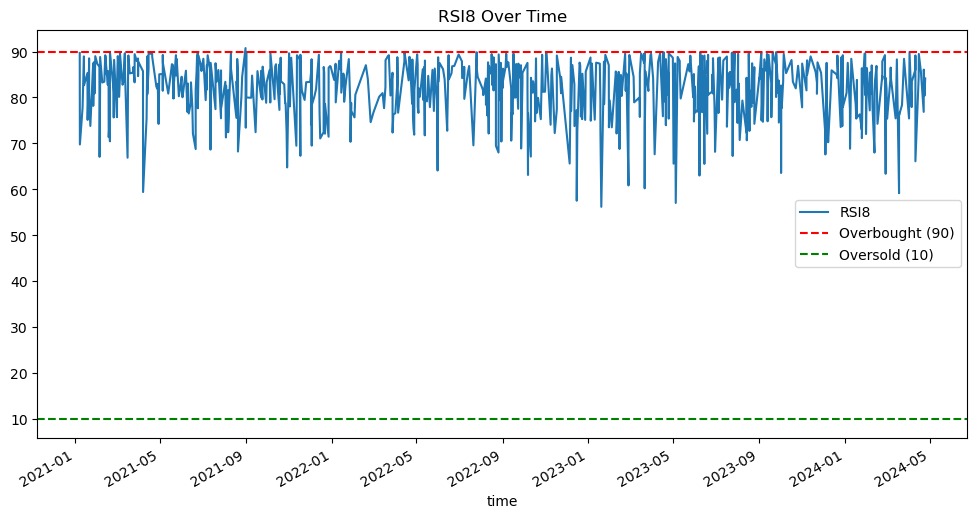

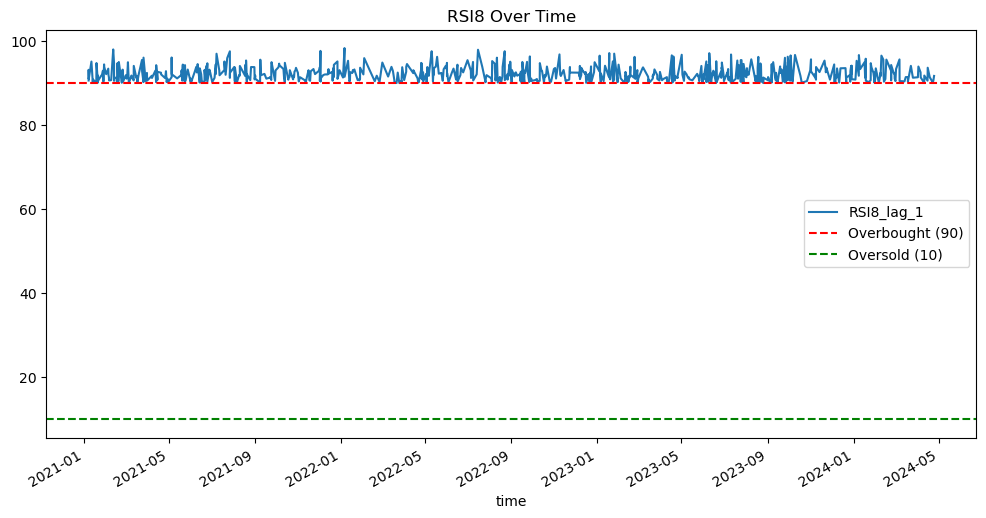

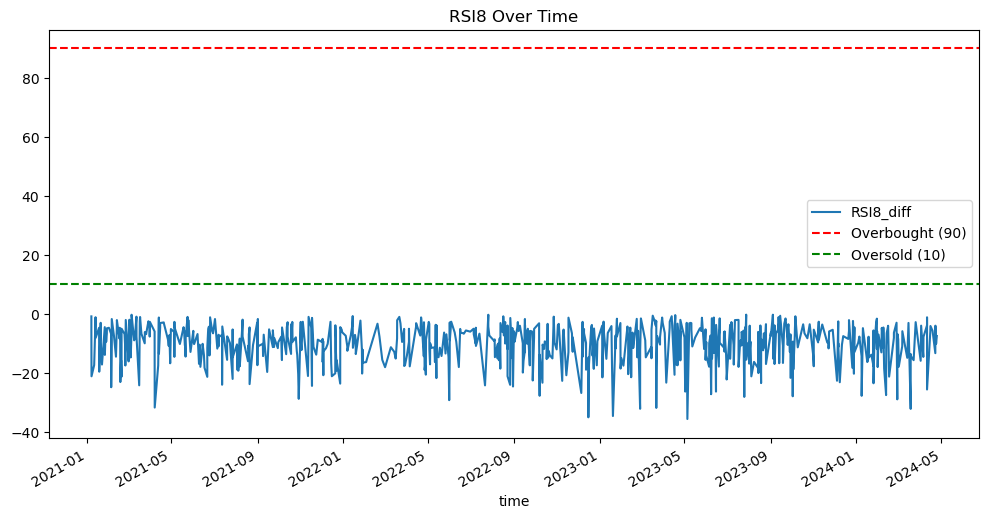

In [23]:
import matplotlib.pyplot as plt

df['RSI8'].plot(figsize=(12,6), title='RSI8 Over Time')
plt.axhline(90, color='r', linestyle='--', label='Overbought (90)')
plt.axhline(10, color='g', linestyle='--', label='Oversold (10)')
plt.legend()
plt.show()


df['RSI8_lag_1'].plot(figsize=(12,6), title='RSI8 Over Time')
plt.axhline(90, color='r', linestyle='--', label='Overbought (90)')
plt.axhline(10, color='g', linestyle='--', label='Oversold (10)')
plt.legend()
plt.show()

df['RSI8_diff'].plot(figsize=(12,6), title='RSI8 Over Time')
plt.axhline(90, color='r', linestyle='--', label='Overbought (90)')
plt.axhline(10, color='g', linestyle='--', label='Oversold (10)')
plt.legend()
plt.show()



In [26]:
rsi_stats = df['RSI8_lag_1'].describe()
print(rsi_stats)



count    735.000000
mean      92.173995
std        1.766851
min       90.001622
25%       90.698713
50%       91.772843
75%       93.212292
max       98.334094
Name: RSI8_lag_1, dtype: float64


In [27]:
rsi_stats = df['RSI8'].describe()
print(rsi_stats)

count    735.000000
mean      82.061763
std        6.343222
min       56.195851
25%       78.614874
50%       83.427301
75%       87.048785
max       90.755554
Name: RSI8, dtype: float64


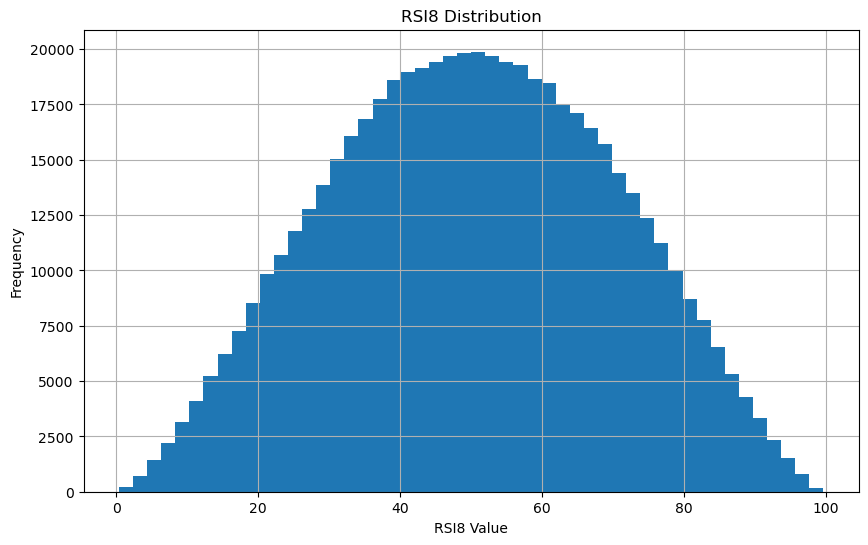

In [28]:
df_trading['RSI8'].hist(bins=50, figsize=(10,6))
plt.title('RSI8 Distribution')
plt.xlabel('RSI8 Value')
plt.ylabel('Frequency')
plt.show()


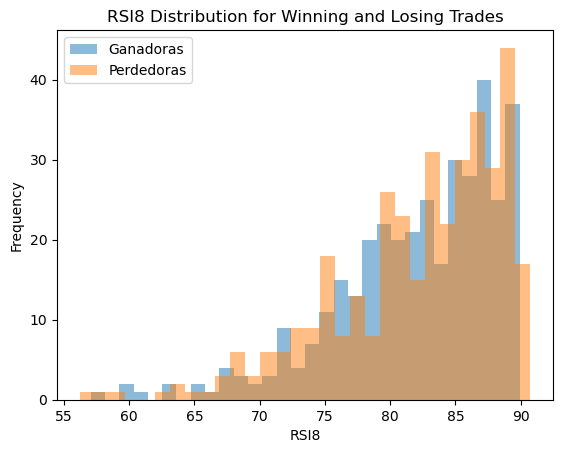

In [35]:
rsi_ganadoras = df[df['result'] == 1]['RSI8']
rsi_perdedoras = df[df['result'] == 0]['RSI8']

plt.hist(rsi_ganadoras, bins=30, alpha=0.5, label='Ganadoras')
plt.hist(rsi_perdedoras, bins=30, alpha=0.5, label='Perdedoras')
plt.title('RSI8 Distribution for Winning and Losing Trades')
plt.xlabel('RSI8')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [37]:
corr_matrix = df.corr()
high_corr = corr_matrix[corr_matrix > 0.9]
high_corr.head(20)


,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,atr_14,ema70_slope,ema250_slope,ema_diff,close_to_ema70,close_to_ema250,RSI8_diff,obv,cmf,volatility_14,return_5,return_10,risk_adjusted_return_5,risk_adjusted_return_10,rsi_volatility_ratio,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,ohlc_avg_lag_1,RSI8_lag_1,EMA70_lag_1,EMA250_lag_1,atr_14_lag_1,ema70_slope_lag_1,ema250_slope_lag_1,ema_diff_lag_1,close_to_ema70_lag_1,close_to_ema250_lag_1,RSI8_diff_lag_1,obv_lag_1,cmf_lag_1,volatility_14_lag_1,return_5_lag_1,return_10_lag_1,risk_adjusted_return_5_lag_1,risk_adjusted_return_10_lag_1,rsi_volatility_ratio_lag_1,Open_mean_10,Open_std_10,Open_min_10,Open_max_10,Open_median_10,High_mean_10,High_std_10,High_min_10,High_max_10,High_median_10,Low_mean_10,Low_std_10,Low_min_10,Low_max_10,Low_median_10,Close_mean_10,Close_std_10,Close_min_10,Close_max_10,Close_median_10,ohlc_avg_mean_10,ohlc_avg_std_10,ohlc_avg_min_10,ohlc_avg_max_10,ohlc_avg_median_10,RSI8_mean_10,RSI8_std_10,RSI8_min_10,RSI8_max_10,RSI8_median_10,EMA70_mean_10,EMA70_std_10,EMA70_min_10,EMA70_max_10,EMA70_median_10,EMA250_mean_10,EMA250_std_10,EMA250_min_10,EMA250_max_10,EMA250_median_10,atr_14_mean_10,atr_14_std_10,atr_14_min_10,atr_14_max_10,atr_14_median_10,ema70_slope_mean_10,ema70_slope_std_10,ema70_slope_min_10,ema70_slope_max_10,ema70_slope_median_10,ema250_slope_mean_10,ema250_slope_std_10,ema250_slope_min_10,ema250_slope_max_10,ema250_slope_median_10,ema_diff_mean_10,ema_diff_std_10,ema_diff_min_10,ema_diff_max_10,ema_diff_median_10,close_to_ema70_mean_10,close_to_ema70_std_10,close_to_ema70_min_10,close_to_ema70_max_10,close_to_ema70_median_10,close_to_ema250_mean_10,close_to_ema250_std_10,close_to_ema250_min_10,close_to_ema250_max_10,close_to_ema250_median_10,RSI8_diff_mean_10,RSI8_diff_std_10,RSI8_diff_min_10,RSI8_diff_max_10,RSI8_diff_median_10,obv_mean_10,obv_std_10,obv_min_10,obv_max_10,obv_median_10,cmf_mean_10,cmf_std_10,cmf_min_10,cmf_max_10,cmf_median_10,volatility_14_mean_10,volatility_14_std_10,volatility_14_min_10,volatility_14_max_10,volatility_14_median_10,return_5_mean_10,return_5_std_10,return_5_min_10,return_5_max_10,return_5_median_10,return_10_mean_10,return_10_std_10,return_10_min_10,return_10_max_10,return_10_median_10,risk_adjusted_return_5_mean_10,risk_adjusted_return_5_std_10,risk_adjusted_return_5_min_10,risk_adjusted_return_5_max_10,risk_adjusted_return_5_median_10,risk_adjusted_return_10_mean_10,risk_adjusted_return_10_std_10,risk_adjusted_return_10_min_10,risk_adjusted_return_10_max_10,risk_adjusted_return_10_median_10,rsi_volatility_ratio_mean_10,rsi_volatility_ratio_std_10,rsi_volatility_ratio_min_10,rsi_volatility_ratio_max_10,rsi_volatility_ratio_median_10,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result,RSI8_slope
Open,1.000000,0.999999,0.999992,0.999993,NaN,0.999998,0.999844,0.999730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999994,0.999993,0.999998,1.000000,0.999998,NaN,0.999836,0.999725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999951,NaN,0.999809,0.999997,0.999918,0.999962,NaN,0.999827,0.999992,0.999932,0.999944,NaN,0.999793,0.999998,0.999911,0.999956,NaN,0.999815,0.999997,0.999928,0.999954,NaN,0.999816,0.999998,0.999923,NaN,NaN,NaN,NaN,NaN,0.999807,NaN,0.999776,0.999842,0.999804,0.999711,NaN,0.999714,0.999710,0.999711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999993,0.999940,NaN,NaN,NaN,NaN,NaN,NaN
High,0.999999,1.000000,0.999991,0.999992,NaN,0.999998,0.999836,0.999722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999995,0.999995,0.999996,0.999999,0.999998,NaN,0.999827,0.999718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999946,NaN,0.999802,0.999997,0.999913,0.999959,NaN

# Parte 3: Modelado

In [50]:
# No normalizo ni estandrizado los datos porque para los arboles de decisiones no es estrictamente necesario


for col in df.columns:
    print(col)


Open
High
Low
Close
Volume
ohlc_avg
EMA70
EMA250
RSI8
perc_var_open_close
candle_range_perc
body_size_perc
upper_shadow_perc
lower_shadow_perc
upper_shadow_ratio
lower_shadow_ratio
body_to_range_ratio
perc_var_open_close_mean_3
perc_var_open_close_std_3
perc_var_open_close_min_3
perc_var_open_close_max_3
perc_var_open_close_median_3
candle_range_perc_mean_3
candle_range_perc_std_3
candle_range_perc_min_3
candle_range_perc_max_3
candle_range_perc_median_3
upper_shadow_ratio_mean_3
upper_shadow_ratio_std_3
lower_shadow_ratio_mean_3
lower_shadow_ratio_std_3
body_to_range_ratio_mean_3
body_to_range_ratio_std_3
RSI8_mean_3
RSI8_std_3
RSI8_min_3
RSI8_25%_3
RSI8_50%_3
RSI8_75%_3
RSI8_max_3
RSI8_slope_5
EMA70_mean_3
EMA70_std_3
EMA70_min_3
EMA70_max_3
EMA70_median_3
EMA250_mean_3
EMA250_std_3
EMA250_min_3
EMA250_max_3
EMA250_median_3
ema_diff
ema_diff_mean_3
ema_diff_std_3
ema_diff_min_3
ema_diff_max_3
ema_diff_median_3
close_to_ema70
close_to_ema250
close_to_ema70_mean_3
close_to_ema70_std_3


## El primer enfoque es usar selector de features

In [55]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result',
                   'RSI8','EMA70','EMA250'
]

X = df.drop(columns=columns_to_drop)
y = df['result']


# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.483
LGBMClassifier: Mean AUC Score=0.511
CatBoostClassifier: Mean AUC Score=0.514
RandomForestClassifier: Mean AUC Score=0.524


In [ ]:
Lag de 3
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result','RSI8','EMA70','EMA250']

XGBClassifier: Mean AUC Score=0.483
LGBMClassifier: Mean AUC Score=0.511
CatBoostClassifier: Mean AUC Score=0.514
RandomForestClassifier: Mean AUC Score=0.524

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],           # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],                  # Profundidad máxima del árbol (None para sin límite)
    'min_samples_split': [2, 5, 10],                  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                    # Mínimo número de muestras en cada hoja
    'max_features': ['auto', 'sqrt', 'log2'],         # Número de características a considerar para encontrar la mejor división
    'bootstrap': [True, False],                       # Método de muestreo (con reemplazo o sin reemplazo)
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
Mejor modelo después de optimización: RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000, random_state=42)


In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_rf = RandomForestClassifier(
    n_estimators=1500, 
    max_depth=20, 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='log2', 
    bootstrap=False, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=10)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_rf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_rf.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.554, F1-Score = 0.540, Precision = 0.654, Recall = 0.459

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.49      0.68      0.57        28
         1.0       0.65      0.46      0.54        37

    accuracy                           0.55        65
   macro avg       0.57      0.57      0.55        65
weighted avg       0.58      0.55      0.55        65

Matriz de Confusión:
[[19  9]
 [20 17]]
Fold: Accuracy = 0.585, F1-Score = 0.542, Precision = 0.571, Recall = 0.516

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.59      0.65      0.62        34
         1.0       0.57      0.52      0.54        31

    accuracy                           0.58        65
   macro avg       0.58      0.58      0.58        65
weighted avg       0.58      0.58      0.58        65

Matriz de Confusión:
[[22 12]
 [15 16]]
Fold: Accuracy = 0.492, F1-Score = 0.441, Precision = 0.500,

In [65]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_rf, '2modelo_rf_longs_15-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


In [59]:
# Mejora pero no por muccho  vamos a probar ahora cat

In [60]:
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo CatBoostClassifier
clf = CatBoostClassifier(random_state=42, silent=True)

# Hiperparámetros reducidos para optimización
param_grid = {
    'iterations': [200, 500, 1000],                # Número de iteraciones reducido
    'learning_rate': [0.05, 0.1],                  # Tasas de aprendizaje reducidas
    'depth': [6, 8, 10],                           # Profundidad máxima del árbol
    'l2_leaf_reg': [3, 5],                         # Regularización L2
    'scale_pos_weight': [1, 2]                     # Peso para clases desbalanceadas
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con menos combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=20, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'scale_pos_weight': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 10}
Mejor modelo después de optimización: <catboost.core.CatBoostClassifier object at 0x000001F9CEA0BD50>


In [62]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo CatBoostClassifier con los mejores hiperparámetros
modelo_catboost = CatBoostClassifier(
    iterations=500, 
    depth=10, 
    learning_rate=0.05, 
    l2_leaf_reg=3, 
    scale_pos_weight=1, 
    random_state=42,
    silent=True  # Mantener salida del entrenamiento en silencio
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_catboost.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_catboost.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.500, F1-Score = 0.268, Precision = 0.500, Recall = 0.183

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.50      0.82      0.62        60
         1.0       0.50      0.18      0.27        60

    accuracy                           0.50       120
   macro avg       0.50      0.50      0.44       120
weighted avg       0.50      0.50      0.44       120

Matriz de Confusión:
[[49 11]
 [49 11]]
Fold: Accuracy = 0.517, F1-Score = 0.567, Precision = 0.535, Recall = 0.603

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.49      0.42      0.45        57
         1.0       0.54      0.60      0.57        63

    accuracy                           0.52       120
   macro avg       0.51      0.51      0.51       120
weighted avg       0.51      0.52      0.51       120

Matriz de Confusión:
[[24 33]
 [25 38]]
Fold: Accuracy = 0.425, F1-Score = 0.448, Precision = 0.467,

In [ ]:
Promedio Accuracy: 0.505
Promedio F1-Score: 0.517
Promedio Precision: 0.537
Promedio Recall: 0.533

# ESTO ES LO VIEJO 

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo CatBoostClassifier
clf = CatBoostClassifier(random_state=42, silent=True)

# Hiperparámetros reducidos para optimización
param_grid = {
    'iterations': [200, 500, 1000],                # Número de iteraciones reducido
    'learning_rate': [0.05, 0.1],                  # Tasas de aprendizaje reducidas
    'depth': [6, 8, 10],                           # Profundidad máxima del árbol
    'l2_leaf_reg': [3, 5],                         # Regularización L2
    'scale_pos_weight': [1, 2]                     # Peso para clases desbalanceadas
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con menos combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=20, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


KeyboardInterrupt: 

In [43]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo CatBoostClassifier con los mejores hiperparámetros
modelo_catboost = CatBoostClassifier(
    iterations=200, 
    depth=6, 
    learning_rate=0.05, 
    l2_leaf_reg=5, 
    scale_pos_weight=2, 
    random_state=42,
    silent=True  # Mantener salida del entrenamiento en silencio
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=10)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_catboost.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_catboost.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.515, F1-Score = 0.636, Precision = 0.509, Recall = 0.848

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.55      0.18      0.27        33
         1.0       0.51      0.85      0.64        33

    accuracy                           0.52        66
   macro avg       0.53      0.52      0.45        66
weighted avg       0.53      0.52      0.45        66

Matriz de Confusión:
[[ 6 27]
 [ 5 28]]
Fold: Accuracy = 0.485, F1-Score = 0.564, Precision = 0.458, Recall = 0.733

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.56      0.28      0.37        36
         1.0       0.46      0.73      0.56        30

    accuracy                           0.48        66
   macro avg       0.51      0.51      0.47        66
weighted avg       0.51      0.48      0.46        66

Matriz de Confusión:
[[10 26]
 [ 8 22]]
Fold: Accuracy = 0.470, F1-Score = 0.507, Precision = 0.600,

In [56]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_catboost, 'modelo_xgboost_shorts_15-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


# ESTE FUE NOJODA 

In [25]:
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE

# Usar CatBoostClassifier
model = CatBoostClassifier(random_state=42, verbose=False)

# Definir el número de características que deseas seleccionar
n_features_to_select = 21  # Puedes ajustar este número

# Aplicar RFE con CatBoostClassifier
selector = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
selector.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[selector.support_]

# Actualizar X_reduced con las características seleccionadas
X_reduced_CatBoost = X_train[selected_features]

# Ver información sobre las características seleccionadas
X_reduced_CatBoost.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 613 entries, 2021-01-07 06:39:00 to 2023-09-14 14:35:00
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   candle_range_perc              613 non-null    float64
 1   body_to_range_ratio            613 non-null    float64
 2   perc_var_open_close_max_10     613 non-null    float64
 3   candle_range_perc_std_10       613 non-null    float64
 4   candle_range_perc_min_10       613 non-null    float64
 5   upper_shadow_ratio_mean_10     613 non-null    float64
 6   lower_shadow_ratio_mean_10     613 non-null    float64
 7   body_to_range_ratio_std_10     613 non-null    float64
 8   RSI8_75%_10                    613 non-null    float64
 9   RSI8_max_10                    613 non-null    float64
 10  EMA70_std_10                   613 non-null    float64
 11  EMA70_max_10                   613 non-null    float64
 12  EMA_ratio    

In [28]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result',  
                   #'EMA70','obv_lag_1','EMA250','High','Low','Close','EMA70_lag_1','High_lag_1','Open_lag_1','EMA250_lag_1',
                   #'ohlc_avg_lag_1','Close_lag_1','Low_lag_1','ohlc_avg'        
]

X = X_reduced_CatBoost.copy()
y = df['result']


# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 20
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.510
LGBMClassifier: Mean AUC Score=0.521
CatBoostClassifier: Mean AUC Score=0.516
RandomForestClassifier: Mean AUC Score=0.541


In [ ]:
XGBClassifier: Mean AUC Score=0.540
LGBMClassifier: Mean AUC Score=0.526
CatBoostClassifier: Mean AUC Score=0.519
RandomForestClassifier: Mean AUC Score=0.531 

#   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   candle_range_perc               735 non-null    float64
 1   body_to_range_ratio             735 non-null    float64
 2   perc_var_open_close_median_10   735 non-null    float64
 3   candle_range_perc_std_10        735 non-null    float64
 4   candle_range_perc_min_10        735 non-null    float64
 5   candle_range_perc_max_10        735 non-null    float64
 6   upper_shadow_ratio_mean_10      735 non-null    float64
 7   lower_shadow_ratio_mean_10      735 non-null    float64
 8   lower_shadow_ratio_std_10       735 non-null    float64
 9   body_to_range_ratio_std_10      735 non-null    float64
 10  RSI8_25%_10                     735 non-null    float64
 11  RSI8_75%_10                     735 non-null    float64
 12  RSI8_max_10                     735 non-null    float64
 13  EMA250_mean_10                  735 non-null    float64
 14  EMA250_std_10                   735 non-null    float64
 15  ema_diff_max_10                 735 non-null    float64
 16  EMA70_slope_10                  735 non-null    float64
 17  Volume_relative_10              735 non-null    float64
 18  obv                             735 non-null    float64
 19  obv_slope_10                    735 non-null    float64
 20  cmf_20                          735 non-null    float64
 21  cmf_mean_10                     735 non-null    float64
 22  cmf_std_10                      735 non-null    float64
 23  cmf_slope_10                    735 non-null    float64
 24  return_5                        735 non-null    float64
 25  risk_adjusted_return_5          735 non-null    float64
 26  risk_adjusted_return_10         735 non-null    float64
 27  return_5_std_10                 735 non-null    float64
 28  risk_adjusted_return_10_std_10  735 non-null    float64
 29  rsi_volatility_ratio_std_10     735 non-null    float64
 30  rsi_volatility_ratio_slope_10   735 non-null    float64


XGBClassifier: Mean AUC Score=0.550
LGBMClassifier: Mean AUC Score=0.536
CatBoostClassifier: Mean AUC Score=0.537
RandomForestClassifier: Mean AUC Score=0.532


 0   body_to_range_ratio             735 non-null    float64
 1   perc_var_open_close_median_10   735 non-null    float64
 2   candle_range_perc_std_10        735 non-null    float64
 3   candle_range_perc_min_10        735 non-null    float64
 4   candle_range_perc_max_10        735 non-null    float64
 5   upper_shadow_ratio_mean_10      735 non-null    float64
 6   body_to_range_ratio_std_10      735 non-null    float64
 7   RSI8_25%_10                     735 non-null    float64
 8   RSI8_75%_10                     735 non-null    float64
 9   RSI8_max_10                     735 non-null    float64
 10  EMA250_std_10                   735 non-null    float64
 11  ema_diff_max_10                 735 non-null    float64
 12  cmf_mean_10                     735 non-null    float64
 13  cmf_std_10                      735 non-null    float64
 14  cmf_slope_10                    735 non-null    float64
 15  return_5                        735 non-null    float64
 16  risk_adjusted_return_5          735 non-null    float64
 17  risk_adjusted_return_10         735 non-null    float64
 18  return_5_std_10                 735 non-null    float64
 19  risk_adjusted_return_10_std_10  735 non-null    float64
 20  rsi_volatility_ratio_std_10     735 non-null    float64

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

X = X_reduced_forest.copy()
y = df['result']

# Definir el modelo XGBClassifier
clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [100, 200, 500, 1000, 1500],        # Número de árboles en el bosque
    'max_depth': [3, 5, 7, 10, 15, 20],                # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],# Tasa de aprendizaje
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],       # Fracción de datos utilizada para entrenar cada árbol
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],# Fracción de características utilizadas para entrenar cada árbol
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],             # Reducción mínima de la pérdida para realizar una división
    'min_child_weight': [1, 2, 3, 4, 5],               # Mínimo número de instancias requeridas en un nodo hoja
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10],         # Regularización L1
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10],        # Regularización L2
    'scale_pos_weight': [1, 2, 5, 10],                 # Compensar desbalance en las clases
    'max_delta_step': [0, 1, 2, 5],                    # Paso máximo en cada iteración
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=100, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'subsample': 1.0, 'scale_pos_weight': 5, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 7, 'max_delta_step': 2, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Mejor modelo después de optimización: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=2, max_depth=7,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tre

C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo XGBClassifier con los mejores hiperparámetros
modelo_xgboost = XGBClassifier(
    subsample=1.0,
    scale_pos_weight=5,
    reg_lambda=1,
    reg_alpha=0.1,
    n_estimators=100,
    min_child_weight=4,
    max_depth=7,
    max_delta_step=2,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Evitar warnings sobre la métrica de evaluación
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_xgboost.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_xgboost.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 10 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.508, F1-Score = 0.625, Precision = 0.532, Recall = 0.758

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.43      0.21      0.29        56
         1.0       0.53      0.76      0.62        66

    accuracy                           0.51       122
   macro avg       0.48      0.49      0.46       122
weighted avg       0.48      0.51      0.47       122

Matriz de Confusión:
[[12 44]
 [16 50]]
Fold: Accuracy = 0.516, F1-Score = 0.614, Precision = 0.495, Recall = 0.810

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.59      0.25      0.35        64
         1.0       0.49      0.81      0.61        58

    accuracy                           0.52       122
   macro avg       0.54      0.53      0.48       122
weighted avg       0.55      0.52      0.48       122

Matriz de Confusión:
[[16 48]
 [11 47]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.574, F1-Score = 0.671, Precision = 0.552, Recall = 0.855

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.65      0.28      0.40        60
         1.0       0.55      0.85      0.67        62

    accuracy                           0.57       122
   macro avg       0.60      0.57      0.53       122
weighted avg       0.60      0.57      0.54       122

Matriz de Confusión:
[[17 43]
 [ 9 53]]
Fold: Accuracy = 0.541, F1-Score = 0.641, Precision = 0.515, Recall = 0.847

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.64      0.25      0.36        63
         1.0       0.52      0.85      0.64        59

    accuracy                           0.54       122
   macro avg       0.58      0.55      0.50       122
weighted avg       0.58      0.54      0.50       122

Matriz de Confusión:
[[16 47]
 [ 9 50]]
Fold: Accuracy = 0.500, F1-Score = 0.555, Precision = 0.452,

C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_xgboost, 'modelo_xgboost_shorts_14-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


In [37]:
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo CatBoostClassifier
clf = CatBoostClassifier(random_state=42, silent=True)

# Hiperparámetros reducidos para optimización
param_grid = {
    'iterations': [200, 500, 1000],                # Número de iteraciones reducido
    'learning_rate': [0.05, 0.1],                  # Tasas de aprendizaje reducidas
    'depth': [6, 8, 10],                           # Profundidad máxima del árbol
    'l2_leaf_reg': [3, 5],                         # Regularización L2
    'scale_pos_weight': [1, 2]                     # Peso para clases desbalanceadas
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con menos combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=20, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'scale_pos_weight': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 6}
Mejor modelo después de optimización: <catboost.core.CatBoostClassifier object at 0x00000208E720F250>


In [39]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo CatBoostClassifier con los mejores hiperparámetros
modelo_catboost = CatBoostClassifier(
    iterations=500, 
    depth=6, 
    learning_rate=0.05, 
    l2_leaf_reg=5, 
    scale_pos_weight=1, 
    random_state=42,
    silent=True  # Mantener salida del entrenamiento en silencio
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_catboost.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_catboost.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.508, F1-Score = 0.615, Precision = 0.533, Recall = 0.727

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.44      0.25      0.32        56
         1.0       0.53      0.73      0.62        66

    accuracy                           0.51       122
   macro avg       0.49      0.49      0.47       122
weighted avg       0.49      0.51      0.48       122

Matriz de Confusión:
[[14 42]
 [18 48]]
Fold: Accuracy = 0.500, F1-Score = 0.534, Precision = 0.479, Recall = 0.603

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.53      0.41      0.46        64
         1.0       0.48      0.60      0.53        58

    accuracy                           0.50       122
   macro avg       0.51      0.50      0.50       122
weighted avg       0.51      0.50      0.50       122

Matriz de Confusión:
[[26 38]
 [23 35]]
Fold: Accuracy = 0.574, F1-Score = 0.594, Precision = 0.576,

In [40]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_catboost, 'modelo_catboost_shorts_14-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


In [41]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo LGBMClassifier
clf = LGBMClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],            # Aumentar el número de árboles
    'learning_rate': [0.01, 0.05, 0.1, 0.2],           # Tasas de aprendizaje
    'max_depth': [-1, 10, 20, 30],                     # Profundidad máxima del árbol (-1 para ilimitado)
    'num_leaves': [31, 40, 50, 60],                    # Número máximo de hojas en cada árbol
    'min_child_samples': [10, 20, 30],                 # Mínimo número de muestras en una hoja
    'subsample': [0.6, 0.8, 1.0],                      # Porcentaje de datos utilizados para entrenar cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0],               # Fracción de características utilizadas por árbol
    'boosting_type': ['gbdt', 'dart'],                 # Tipo de boosting
    'reg_alpha': [0, 0.1, 0.5],                        # Regularización L1
    'reg_lambda': [0, 0.1, 0.5],                       # Regularización L2
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 40, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 30, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'boosting_type': 'dart'}
Mejor modelo después de optimización: LGBMClassifier(boosting_type='dart', colsample_bytree=0.8, learning_rate=0.05,
               max_depth=30, min_child_samples=30, n_estimators=500,
               num_leaves=40, random_state=42, reg_alpha=0, reg_lambda=0,
               subsample=0.8)


In [42]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo LGBMClassifier con los mejores hiperparámetros
modelo_lgbm = LGBMClassifier(
    n_estimators=500, 
    max_depth=30, 
    learning_rate=0.05, 
    num_leaves=40, 
    min_child_samples=30, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    reg_alpha=0, 
    reg_lambda=0, 
    boosting_type='dart', 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_lgbm.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_lgbm.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.549, F1-Score = 0.604, Precision = 0.575, Recall = 0.636

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.51      0.45      0.48        56
         1.0       0.58      0.64      0.60        66

    accuracy                           0.55       122
   macro avg       0.54      0.54      0.54       122
weighted avg       0.55      0.55      0.55       122

Matriz de Confusión:
[[25 31]
 [24 42]]
Fold: Accuracy = 0.541, F1-Score = 0.569, Precision = 0.514, Recall = 0.638

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.58      0.45      0.51        64
         1.0       0.51      0.64      0.57        58

    accuracy                           0.54       122
   macro avg       0.55      0.55      0.54       122
weighted avg       0.55      0.54      0.54       122

Matriz de Confusión:
[[29 35]
 [21 37]]
Fold: Accuracy = 0.615, F1-Score = 0.630, Precision = 0.615,

In [43]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_lgbm, 'modelo_lgbm_shorts_14-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


In [ ]:
# RANDOM

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],           # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],                  # Profundidad máxima del árbol (None para sin límite)
    'min_samples_split': [2, 5, 10],                  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                    # Mínimo número de muestras en cada hoja
    'max_features': ['auto', 'sqrt', 'log2'],         # Número de características a considerar para encontrar la mejor división
    'bootstrap': [True, False],                       # Método de muestreo (con reemplazo o sin reemplazo)
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


ValueError: Found input variables with inconsistent numbers of samples: [613, 735]

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    min_samples_split=10, 
    min_samples_leaf=1, 
    max_features='auto', 
    bootstrap=True, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_rf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_rf.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Fold: Accuracy = 0.516, F1-Score = 0.576, Precision = 0.548, Recall = 0.606

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.47      0.41      0.44        56
         1.0       0.55      0.61      0.58        66

    accuracy                           0.52       122
   macro avg       0.51      0.51      0.51       122
weighted avg       0.51      0.52      0.51       122

Matriz de Confusión:
[[23 33]
 [26 40]]
Fold: Accuracy = 0.541, F1-Score = 0.576, Precision = 0.514, Recall = 0.655

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.58      0.44      0.50        64
         1.0       0.51      0.66      0.58        58

    accuracy                           0.54       122
   macro avg       0.55      0.55      0.54       122
weighted avg       0.55      0.54      0.54       122

Matriz de Confusión:
[[28 36]
 [20 38]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Fold: Accuracy = 0.574, F1-Score = 0.587, Precision = 0.578, Recall = 0.597

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.57      0.55      0.56        60
         1.0       0.58      0.60      0.59        62

    accuracy                           0.57       122
   macro avg       0.57      0.57      0.57       122
weighted avg       0.57      0.57      0.57       122

Matriz de Confusión:
[[33 27]
 [25 37]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Fold: Accuracy = 0.557, F1-Score = 0.585, Precision = 0.535, Recall = 0.644

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.59      0.48      0.53        63
         1.0       0.54      0.64      0.58        59

    accuracy                           0.56       122
   macro avg       0.56      0.56      0.56       122
weighted avg       0.56      0.56      0.55       122

Matriz de Confusión:
[[30 33]
 [21 38]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Fold: Accuracy = 0.500, F1-Score = 0.419, Precision = 0.423, Recall = 0.415

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.56      0.57      0.56        69
         1.0       0.42      0.42      0.42        53

    accuracy                           0.50       122
   macro avg       0.49      0.49      0.49       122
weighted avg       0.50      0.50      0.50       122

Matriz de Confusión:
[[39 30]
 [31 22]]

Promedio Accuracy: 0.538
Promedio F1-Score: 0.548
Promedio Precision: 0.520
Promedio Recall: 0.583


In [47]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_rf, 'modelo_rf_shorts_14-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


In [ ]:
Hasta aqui llegue 

In [ ]:
Estos resultados fueron con la 2da ventana que tienes de features y con lo de abajo, solo con las primeras y los features a 10

LGBMClassifier: Mean AUC Score=0.538 con las primeras 41 features, esta probable a ver,

hay resultados mas estable con solo 31 : (Estos resultados fueron con las primeras features con 10 de lag)

XGBClassifier: Mean AUC Score=0.526
LGBMClassifier: Mean AUC Score=0.536
CatBoostClassifier: Mean AUC Score=0.528
RandomForestClassifier: Mean AUC Score=0.531

puedes jugar con los ultimos promedios no las 10 velas si no ultimas 15 o 20 a ver como se comporta y agregar otros alli mismo.


In [142]:
Prueba esta enfoque logico de agregar bastantes indicadores con 10 de lag esta muy bueno
XGBClassifier: Mean AUC Score=0.529
LGBMClassifier: Mean AUC Score=0.536
CatBoostClassifier: Mean AUC Score=0.527
RandomForestClassifier: Mean AUC Score=0.527

Esto es con lo que hiciste con chatgpt con 51 features 

al bajar a 41 obtienes mejores resultados
XGBClassifier: Mean AUC Score=0.544
LGBMClassifier: Mean AUC Score=0.546
CatBoostClassifier: Mean AUC Score=0.531
RandomForestClassifier: Mean AUC Score=0.521

Los 2 primeros estan entrenables para ver resultados! 

Con solo 21 caracteristicas obtienes los mejores resultados hasta ahora 
XGBClassifier: Mean AUC Score=0.532
LGBMClassifier: Mean AUC Score=0.566
CatBoostClassifier: Mean AUC Score=0.570
RandomForestClassifier: Mean AUC Score=0.560

 0   Volume                            735 non-null    int64  
 1   RSI8                              735 non-null    float64
 2   cmf                               735 non-null    float64
 3   risk_adjusted_return_5            735 non-null    float64
 4   RSI8_lag_1                        735 non-null    float64
 5   ema_diff_lag_1                    735 non-null    float64
 6   RSI8_diff_lag_1                   735 non-null    float64
 7   RSI8_max_10                       735 non-null    float64
 8   EMA250_std_10                     735 non-null    float64
 9   atr_14_std_10                     735 non-null    float64
 10  RSI8_diff_std_10                  735 non-null    float64
 11  RSI8_diff_min_10                  735 non-null    float64
 12  obv_min_10                        735 non-null    float64
 13  cmf_std_10                        735 non-null    float64
 14  cmf_min_10                        735 non-null    float64
 15  volatility_14_min_10              735 non-null    float64
 16  return_5_std_10                   735 non-null    float64
 17  risk_adjusted_return_5_min_10     735 non-null    float64
 18  risk_adjusted_return_5_median_10  735 non-null    float64
 19  risk_adjusted_return_10_std_10    735 non-null    float64
 20  rsi_volatility_ratio_std_10       735 non-null    float64

EMPIEZA POR AQUI MANANA 

SyntaxError: invalid syntax (2333365747.py, line 1)

## Entrenamiento CatBoostClassifier: Mean AUC Score=0.570

In [21]:
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo CatBoostClassifier
clf = CatBoostClassifier(random_state=42, silent=True)

# Hiperparámetros reducidos para optimización
param_grid = {
    'iterations': [200, 500, 1000],                # Número de iteraciones reducido
    'learning_rate': [0.05, 0.1],                  # Tasas de aprendizaje reducidas
    'depth': [6, 8, 10],                           # Profundidad máxima del árbol
    'l2_leaf_reg': [3, 5],                         # Regularización L2
    'scale_pos_weight': [1, 2]                     # Peso para clases desbalanceadas
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con menos combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=20, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'scale_pos_weight': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 10}
Mejor modelo después de optimización: <catboost.core.CatBoostClassifier object at 0x000002319E038290>


In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo CatBoostClassifier con los mejores hiperparámetros
modelo_catboost = CatBoostClassifier(
    iterations=200, 
    depth=10, 
    learning_rate=0.1, 
    l2_leaf_reg=5, 
    scale_pos_weight=1, 
    random_state=42,
    silent=True  # Mantener salida del entrenamiento en silencio
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=10)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_catboost.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_catboost.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.500, F1-Score = 0.582, Precision = 0.500, Recall = 0.697

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.50      0.30      0.38        33
         1.0       0.50      0.70      0.58        33

    accuracy                           0.50        66
   macro avg       0.50      0.50      0.48        66
weighted avg       0.50      0.50      0.48        66

Matriz de Confusión:
[[10 23]
 [10 23]]
Fold: Accuracy = 0.515, F1-Score = 0.600, Precision = 0.480, Recall = 0.800

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.62      0.28      0.38        36
         1.0       0.48      0.80      0.60        30

    accuracy                           0.52        66
   macro avg       0.55      0.54      0.49        66
weighted avg       0.56      0.52      0.48        66

Matriz de Confusión:
[[10 26]
 [ 6 24]]
Fold: Accuracy = 0.636, F1-Score = 0.667, Precision = 0.774,

In [24]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_catboost, 'modelo_catboost_shorts_13-10-2022.pkl')
print("Modelo guardado exitosamente.")

El modelo esta como invertido, predice bien la clase 0 que son los trades perdedores como si fueran positivos y cuando hago el backtest da buenos resultados


Modelo guardado exitosamente.


In [25]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo LGBMClassifier
clf = LGBMClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],            # Aumentar el número de árboles
    'learning_rate': [0.01, 0.05, 0.1, 0.2],           # Tasas de aprendizaje
    'max_depth': [-1, 10, 20, 30],                     # Profundidad máxima del árbol (-1 para ilimitado)
    'num_leaves': [31, 40, 50, 60],                    # Número máximo de hojas en cada árbol
    'min_child_samples': [10, 20, 30],                 # Mínimo número de muestras en una hoja
    'subsample': [0.6, 0.8, 1.0],                      # Porcentaje de datos utilizados para entrenar cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0],               # Fracción de características utilizadas por árbol
    'boosting_type': ['gbdt', 'dart'],                 # Tipo de boosting
    'reg_alpha': [0, 0.1, 0.5],                        # Regularización L1
    'reg_lambda': [0, 0.1, 0.5],                       # Regularización L2
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.6, 'boosting_type': 'dart'}
Mejor modelo después de optimización: LGBMClassifier(boosting_type='dart', colsample_bytree=0.6, learning_rate=0.05,
               n_estimators=500, num_leaves=40, random_state=42, reg_alpha=0.1,
               reg_lambda=0, subsample=0.8)


In [29]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo LGBMClassifier con los mejores hiperparámetros
modelo_lgbm = LGBMClassifier(
    n_estimators=500, 
    max_depth=-1, 
    learning_rate=0.05, 
    num_leaves=40, 
    min_child_samples=20, 
    colsample_bytree=0.6, 
    subsample=0.8, 
    reg_alpha=0.1, 
    reg_lambda=0, 
    boosting_type='dart', 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_lgbm.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_lgbm.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.566, F1-Score = 0.690, Precision = 0.562, Recall = 0.894

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.59      0.18      0.27        56
         1.0       0.56      0.89      0.69        66

    accuracy                           0.57       122
   macro avg       0.58      0.54      0.48       122
weighted avg       0.57      0.57      0.50       122

Matriz de Confusión:
[[10 46]
 [ 7 59]]
Fold: Accuracy = 0.516, F1-Score = 0.599, Precision = 0.494, Recall = 0.759

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.58      0.30      0.39        64
         1.0       0.49      0.76      0.60        58

    accuracy                           0.52       122
   macro avg       0.54      0.53      0.50       122
weighted avg       0.54      0.52      0.49       122

Matriz de Confusión:
[[19 45]
 [14 44]]
Fold: Accuracy = 0.525, F1-Score = 0.547, Precision = 0.530,

In [30]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_lgbm, 'modelo_lgbm_shorts_13-10-2022.pkl')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
Un poco mejor, tengo un resultado valido pero no tan bueno, es intenresante como hace lo mismo que el otro,
predice la clase 0 como clase postivia con un tremendo winrate algo esta pasando 

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],           # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],                  # Profundidad máxima del árbol (None para sin límite)
    'min_samples_split': [2, 5, 10],                  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                    # Mínimo número de muestras en cada hoja
    'max_features': ['auto', 'sqrt', 'log2'],         # Número de características a considerar para encontrar la mejor división
    'bootstrap': [True, False],                       # Método de muestreo (con reemplazo o sin reemplazo)
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor modelo después de optimización: RandomForestClassifier(bootstrap=False, max_depth=20, max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1500, random_state=42)


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_rf = RandomForestClassifier(
    n_estimators=1500, 
    max_depth=20, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    max_features='log2', 
    bootstrap=False, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_rf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_rf.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.508, F1-Score = 0.667, Precision = 0.526, Recall = 0.909

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.25      0.04      0.06        56
         1.0       0.53      0.91      0.67        66

    accuracy                           0.51       122
   macro avg       0.39      0.47      0.36       122
weighted avg       0.40      0.51      0.39       122

Matriz de Confusión:
[[ 2 54]
 [ 6 60]]
Fold: Accuracy = 0.533, F1-Score = 0.617, Precision = 0.505, Recall = 0.793

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.61      0.30      0.40        64
         1.0       0.51      0.79      0.62        58

    accuracy                           0.53       122
   macro avg       0.56      0.54      0.51       122
weighted avg       0.56      0.53      0.50       122

Matriz de Confusión:
[[19 45]
 [12 46]]
Fold: Accuracy = 0.566, F1-Score = 0.589, Precision = 0.567,

In [34]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_rf, 'modelo_rf_shorts_13-10-2022.pkl')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [81]:
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Lista de clasificadores que soportan feature_importances_
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Entrenamiento y extracción de importancias
for clf in classifiers:
    clf_name = type(clf).__name__
    clf.fit(X, y)
    if hasattr(clf, 'feature_importances_'):
        importance = clf.feature_importances_
        # Crear una tabla con los nombres de las columnas y su importancia
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        # Convertir a porcentajes
        importance_df['Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
        print(f"\nFeature importances for {clf_name}:\n")
        print(importance_df[['Feature', 'Importance (%)']].to_string(index=False))

# Para CatBoostClassifier, puedes utilizar get_feature_importance
cat_clf = CatBoostClassifier(random_state=42, verbose=False)
cat_clf.fit(X, y)
cat_importance = cat_clf.get_feature_importance()
cat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': cat_importance
}).sort_values(by='Importance', ascending=False)
# Convertir a porcentajes
cat_importance_df['Importance (%)'] = (cat_importance_df['Importance'] / cat_importance_df['Importance'].sum()) * 100
print(f"\nFeature importances for CatBoostClassifier:\n")
print(cat_importance_df[['Feature', 'Importance (%)']].to_string(index=False))



Feature importances for XGBClassifier:

                      Feature  Importance (%)
                    obv_lag_1        4.197199
                volatility_14        4.054133
                  ema70_slope        3.501966
           ema250_slope_lag_1        3.414377
                   High_lag_1        3.324471
         rsi_volatility_ratio        3.146703
                        EMA70        2.985935
              return_10_lag_1        2.898251
                         RSI8        2.816912
         close_to_ema70_lag_1        2.792542
                   RSI8_lag_1        2.736668
              RSI8_diff_lag_1        2.672382
                       EMA250        2.671602
      risk_adjusted_return_10        2.663077
                          Low        2.608759
                         Open        2.603923
               ema_diff_lag_1        2.575416
                 atr_14_lag_1        2.499821
                    RSI8_diff        2.404268
       risk_adjusted_return_5        2.

In [31]:
import pandas as pd
import numpy as np

# Copiar el DataFrame para trabajar
df_features = df.copy()

# Eliminar columnas irrelevantes o no numéricas
# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result']


df_features = df_features.drop(columns=columns_to_drop)

# Calcular la matriz de correlación
corr_matrix = df_features.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 12))

# Establecer un umbral para considerar una correlación como alta
threshold = 0.91

# Seleccionar las correlaciones que superan el umbral (y no son la diagonal)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            high_corr_pairs.append((colname1, colname2, corr_value))

# Mostrar los pares altamente correlacionados
print("Pares de características con correlación alta (|correlación| > 0.91):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: Correlación = {pair[2]:.2f}")



Pares de características con correlación alta (|correlación| > 0.91):
High - Open: Correlación = 1.00
Low - Open: Correlación = 1.00
Low - High: Correlación = 1.00
Close - Open: Correlación = 1.00
Close - High: Correlación = 1.00
Close - Low: Correlación = 1.00
ohlc_avg - Open: Correlación = 1.00
ohlc_avg - High: Correlación = 1.00
ohlc_avg - Low: Correlación = 1.00
ohlc_avg - Close: Correlación = 1.00
EMA70 - Open: Correlación = 1.00
EMA70 - High: Correlación = 1.00
EMA70 - Low: Correlación = 1.00
EMA70 - Close: Correlación = 1.00
EMA70 - ohlc_avg: Correlación = 1.00
EMA250 - Open: Correlación = 1.00
EMA250 - High: Correlación = 1.00
EMA250 - Low: Correlación = 1.00
EMA250 - Close: Correlación = 1.00
EMA250 - ohlc_avg: Correlación = 1.00
EMA250 - EMA70: Correlación = 1.00
close_to_ema70 - ema70_slope: Correlación = 0.99
close_to_ema250 - ema250_slope: Correlación = 0.99
RSI8_diff - RSI8: Correlación = 0.96
Open_lag_1 - Open: Correlación = 1.00
Open_lag_1 - High: Correlación = 1.00
Ope

<Figure size 1600x1200 with 0 Axes>

In [92]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo LGBMClassifier
clf = LGBMClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],            # Aumentar el número de árboles
    'learning_rate': [0.01, 0.05, 0.1, 0.2],           # Tasas de aprendizaje
    'max_depth': [-1, 10, 20, 30],                     # Profundidad máxima del árbol (-1 para ilimitado)
    'num_leaves': [31, 40, 50, 60],                    # Número máximo de hojas en cada árbol
    'min_child_samples': [10, 20, 30],                 # Mínimo número de muestras en una hoja
    'subsample': [0.6, 0.8, 1.0],                      # Porcentaje de datos utilizados para entrenar cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0],               # Fracción de características utilizadas por árbol
    'boosting_type': ['gbdt', 'dart'],                 # Tipo de boosting
    'reg_alpha': [0, 0.1, 0.5],                        # Regularización L1
    'reg_lambda': [0, 0.1, 0.5],                       # Regularización L2
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
Mejor modelo después de optimización: LGBMClassifier(colsample_bytree=0.8, n_estimators=200, random_state=42,
               reg_alpha=0.1, reg_lambda=0.5, subsample=0.6)


In [97]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo LGBMClassifier con los mejores hiperparámetros
modelo_lgbm = LGBMClassifier(
    n_estimators=200, 
    max_depth=-1, 
    learning_rate=0.1, 
    num_leaves=31, 
    min_child_samples=20, 
    colsample_bytree=0.8, 
    subsample=0.6, 
    reg_alpha=0.1, 
    reg_lambda=0.5, 
    boosting_type='gbdt', 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_lgbm.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_lgbm.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.533, F1-Score = 0.642, Precision = 0.548, Recall = 0.773

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.48      0.25      0.33        56
         1.0       0.55      0.77      0.64        66

    accuracy                           0.53       122
   macro avg       0.52      0.51      0.49       122
weighted avg       0.52      0.53      0.50       122

Matriz de Confusión:
[[14 42]
 [15 51]]
Fold: Accuracy = 0.516, F1-Score = 0.576, Precision = 0.494, Recall = 0.690

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.56      0.36      0.44        64
         1.0       0.49      0.69      0.58        58

    accuracy                           0.52       122
   macro avg       0.53      0.52      0.51       122
weighted avg       0.53      0.52      0.50       122

Matriz de Confusión:
[[23 41]
 [18 40]]
Fold: Accuracy = 0.557, F1-Score = 0.585, Precision = 0.559,

# VIEJO

In [13]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result']

X = df.drop(columns=columns_to_drop)
y = df['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.477
LGBMClassifier: Mean AUC Score=0.460


KeyboardInterrupt: 

In [133]:
import numpy as np
import pandas as pd

# Inicializar array de importancias de características
feature_importances = np.zeros(X_train.shape[1])

# Obtener las importancias de características de los modelos entrenados
for clf_name, clf in trained_classifiers.items():
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_).ravel()  # Para modelos lineales, usar los coeficientes
    
    # Sumar las importancias de las características
    feature_importances += importances

# Promediar las importancias entre los clasificadores
feature_importances /= len(trained_classifiers)

# Crear un DataFrame para asociar las importancias con los nombres de las características
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

# Ordenar las características por importancia de mayor a menor
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 20 características más importantes
top_20_features = feature_importance_df['feature'].head(21)

# Actualizar X con las 20 características seleccionadas
X_reduced2 = X[top_20_features]

# Ver información de las 20 características seleccionadas
X_reduced2.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735 entries, 2021-01-07 06:39:00 to 2024-04-24 12:43:00
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   volume_ratio_lag_5       735 non-null    float64
 1   RSI8_diff_lag_1          735 non-null    float64
 2   RSI8_diff_lag_15         735 non-null    float64
 3   volume_ratio             735 non-null    float64
 4   RSI8_lag_1               735 non-null    float64
 5   risk_adjusted_return_10  735 non-null    float64
 6   stoch_d_lag_5            735 non-null    float64
 7   volume_ratio_lag_10      735 non-null    float64
 8   stoch_d_lag_10           735 non-null    float64
 9   cmf_lag_5                735 non-null    float64
 10  distance_to_max_lag_5    735 non-null    float64
 11  RSI8_diff                735 non-null    float64
 12  volume_ratio_lag_15      735 non-null    float64
 13  volume_ratio_lag_1       735 non-null    fl

In [132]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema


X = X_reduced2.copy()
y = df['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.513
LGBMClassifier: Mean AUC Score=0.511
CatBoostClassifier: Mean AUC Score=0.512
RandomForestClassifier: Mean AUC Score=0.528


## RandomForestClassifier: Mean AUC Score=0.566 voy a proceder a entrenarlo de donde sale este resultado?

## seleccionar las 21features mas importantes al entrenar primeramnete los 4 modelos 
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RSI8_lag_1                    735 non-null    float64
 1   volume_ratio_lag_5            735 non-null    float64
 2   RSI8_diff_lag_1               735 non-null    float64
 3   volume_ratio_lag_1            735 non-null    float64
 4   return_5_lag_15               735 non-null    float64
 5   cmf_lag_5                     735 non-null    float64
 6   risk_adjusted_return_10       735 non-null    float64
 7   RSI8_diff_lag_15              735 non-null    float64
 8   atr_14_lag_15                 735 non-null    float64
 9   stoch_d_lag_5                 735 non-null    float64
 10  cmf_lag_15                    735 non-null    float64
 11  cmf                           735 non-null    float64
 12  obv                           735 non-null    float64
 13  risk_adjusted_return_5_lag_5  735 non-null    float64
 14  cmf_lag_1                     735 non-null    float64
 15  RSI8_diff                     735 non-null    float64
 16  stoch_k_lag_1                 735 non-null    float64
 17  return_10_lag_15              735 non-null    float64
 18  stoch_k_lag_5                 735 non-null    float64
 19  Volume                        735 non-null    int64  
 20  RSI8                          735 non-null    float64

In [150]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Columnas que se mantendrán para el modelado
columns_to_keep = [
    'RSI8_lag_1', 'volume_ratio_lag_5', 'RSI8_diff_lag_1', 'volume_ratio_lag_1', 
    'return_5_lag_15', 'cmf_lag_5', 'risk_adjusted_return_10', 'RSI8_diff_lag_15', 
    'atr_14_lag_15', 'stoch_d_lag_5', 'cmf_lag_15', 'cmf', 'obv', 
    'risk_adjusted_return_5_lag_5', 'cmf_lag_1', 'RSI8_diff', 'stoch_k_lag_1', 
    'return_10_lag_15', 'stoch_k_lag_5', 'Volume', 'RSI8'
]

# Filtrar el dataframe para mantener solo las columnas necesarias
X = df[columns_to_keep]
y = df['result']


# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.554
LGBMClassifier: Mean AUC Score=0.534
CatBoostClassifier: Mean AUC Score=0.565
RandomForestClassifier: Mean AUC Score=0.566


# Aqui puedes proceder a entrenar random y cat y ver si ya tienes buenos resultados lo dejas asi

In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],        # Aumentar el número de árboles
    'max_depth': [10, 20, 30, 40, None],           # Aumentar la profundidad máxima
    'min_samples_split': [2, 5, 10, 15],           # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 6],              # Mínimo número de muestras en una hoja
    'max_features': ['sqrt', 'log2'],              # 'sqrt' será el valor por defecto, y 'log2' como opción adicional
    'bootstrap': [True, False],                    # Usar bootstrap en el muestreo
    'criterion': ['gini', 'entropy'],              # Criterio para medir la calidad de la división
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")

Mejores Hiperparámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'gini', 'bootstrap': False}
Mejor modelo después de optimización: RandomForestClassifier(bootstrap=False, max_depth=40, max_features='log2',
                       n_estimators=200, random_state=42)


In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import joblib

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_random_forest = RandomForestClassifier(
    n_estimators=200, 
    max_depth=40, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='log2', 
    criterion='gini', 
    bootstrap=False, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_random_forest.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_random_forest.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 10 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")



Fold: Accuracy = 0.541, F1-Score = 0.689, Precision = 0.544, Recall = 0.939

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.50      0.07      0.12        56
         1.0       0.54      0.94      0.69        66

    accuracy                           0.54       122
   macro avg       0.52      0.51      0.41       122
weighted avg       0.52      0.54      0.43       122

Matriz de Confusión:
[[ 4 52]
 [ 4 62]]
Fold: Accuracy = 0.598, F1-Score = 0.637, Precision = 0.558, Recall = 0.741

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.67      0.47      0.55        64
         1.0       0.56      0.74      0.64        58

    accuracy                           0.60       122
   macro avg       0.61      0.61      0.59       122
weighted avg       0.62      0.60      0.59       122

Matriz de Confusión:
[[30 34]
 [15 43]]
Fold: Accuracy = 0.549, F1-Score = 0.567, Precision = 0.554,

In [162]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_random_forest, 'modelo_random_forest_s 11-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


# tiene buenos resultados pero no funcioan en el nuevo daataframe fina

In [165]:
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo CatBoostClassifier
clf = CatBoostClassifier(random_state=42, silent=True)

# Hiperparámetros para optimización
param_grid = {
    'iterations': [500, 1000, 1500],                   # Número de iteraciones
    'depth': [6, 8, 10],                              # Profundidad de los árboles
    'learning_rate': [0.01, 0.05, 0.1],               # Tasa de aprendizaje
    'l2_leaf_reg': [1, 3, 5, 7],                      # Regularización L2
    'bagging_temperature': [0.0, 0.5, 1.0],           # Controla la aleatoriedad en el muestreo de datos
    'border_count': [32, 64, 128],                    # Número de divisiones de la característica
    'scale_pos_weight': [1, 2, 5],                    # Peso para las clases desbalanceadas
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'scale_pos_weight': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 10, 'border_count': 64, 'bagging_temperature': 1.0}
Mejor modelo después de optimización: <catboost.core.CatBoostClassifier object at 0x00000212893D1110>


In [166]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import joblib

# Definir el modelo CatBoostClassifier con los mejores hiperparámetros
modelo_catboost = CatBoostClassifier(
    scale_pos_weight=5,
    learning_rate=0.1,
    l2_leaf_reg=7,
    iterations=500,
    depth=10,
    border_count=64,
    bagging_temperature=1.0,
    random_state=42,
    silent=True  # Para evitar la salida de logs innecesarios
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_catboost.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_catboost.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")

# Guardar el modelo entrenado
joblib.dump(modelo_catboost, 'catboost_model.pkl')
print("CatBoostClassifier guardado como 'catboost_model.pkl'")


Fold: Accuracy = 0.557, F1-Score = 0.700, Precision = 0.553, Recall = 0.955

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.62      0.09      0.16        56
         1.0       0.55      0.95      0.70        66

    accuracy                           0.56       122
   macro avg       0.59      0.52      0.43       122
weighted avg       0.59      0.56      0.45       122

Matriz de Confusión:
[[ 5 51]
 [ 3 63]]
Fold: Accuracy = 0.574, F1-Score = 0.667, Precision = 0.531, Recall = 0.897

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.75      0.28      0.41        64
         1.0       0.53      0.90      0.67        58

    accuracy                           0.57       122
   macro avg       0.64      0.59      0.54       122
weighted avg       0.65      0.57      0.53       122

Matriz de Confusión:
[[18 46]
 [ 6 52]]
Fold: Accuracy = 0.541, F1-Score = 0.650, Precision = 0.531,

## Volvemos nuevamente a hacer otra itereacion, el enfofque es buscar los mejores hiperametros para cada features de cada modelo usando RFE

### Los probe con todos XGB no da buenos resultados muy bajos 

In [141]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'ohlc_avg', 'EMA70', 'EMA250',
       'RSI8', 'atr_14',
       ...
       'risk_adjusted_return_10_lag_5', 'risk_adjusted_return_10_lag_10',
       'risk_adjusted_return_10_lag_15', 'EntryPrice', 'ExitPrice', 'PnL',
       'EntryTime', 'ExitTime', 'Duration', 'result'],
      dtype='object', length=171)

In [142]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result']

X = df.drop(columns=columns_to_drop)
y = df['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.477
LGBMClassifier: Mean AUC Score=0.460
CatBoostClassifier: Mean AUC Score=0.456
RandomForestClassifier: Mean AUC Score=0.484


In [143]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Supongamos que estás usando RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Definir el número de características que deseas seleccionar
n_features_to_select = 21  # Puedes ajustar este número

selector = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
selector.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[selector.support_]

# Actualizar X_reduced con las características seleccionadas
X_reduced_forest = X[selected_features]
X_reduced_forest.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735 entries, 2021-01-07 06:39:00 to 2024-04-24 12:43:00
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RSI8                           735 non-null    float64
 1   RSI8_diff                      735 non-null    float64
 2   volume_ratio                   735 non-null    float64
 3   bb_width                       735 non-null    float64
 4   risk_adjusted_return_5         735 non-null    float64
 5   risk_adjusted_return_10        735 non-null    float64
 6   RSI8_lag_1                     735 non-null    float64
 7   RSI8_diff_lag_1                735 non-null    float64
 8   RSI8_diff_lag_15               735 non-null    float64
 9   stoch_k_lag_15                 735 non-null    float64
 10  stoch_d_lag_10                 735 non-null    float64
 11  stoch_d_lag_15                 735 non-null    float64
 12  macd_signal_l

In [144]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

X = X_reduced_forest.copy()
y = df['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.550
LGBMClassifier: Mean AUC Score=0.541
CatBoostClassifier: Mean AUC Score=0.550
RandomForestClassifier: Mean AUC Score=0.552


In [145]:
df1= df.copy()

import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result']

X = df1.drop(columns=columns_to_drop)
y = df1['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.477
LGBMClassifier: Mean AUC Score=0.460
CatBoostClassifier: Mean AUC Score=0.456
RandomForestClassifier: Mean AUC Score=0.484


In [146]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE

# Supongamos que estás usando XGBClassifier
model = XGBClassifier(random_state=42, eval_metric='logloss')

# Definir el número de características que deseas seleccionar
n_features_to_select = 21  # Puedes ajustar este número

# Aplicar RFE con XGBClassifier
selector = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
selector.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[selector.support_]

# Actualizar X_reduced con las características seleccionadas
X_reduced_xgb = X_train[selected_features]

# Ver información sobre las características seleccionadas
X_reduced_xgb.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 669 entries, 2021-01-07 06:39:00 to 2023-12-29 06:00:00
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   RSI8                            669 non-null    float64
 1   ema70_slope                     669 non-null    float64
 2   RSI8_diff                       669 non-null    float64
 3   risk_adjusted_return_10         669 non-null    float64
 4   distance_to_max                 669 non-null    float64
 5   RSI8_lag_1                      669 non-null    float64
 6   RSI8_lag_10                     669 non-null    float64
 7   RSI8_lag_15                     669 non-null    float64
 8   ema_diff_lag_5                  669 non-null    float64
 9   RSI8_diff_lag_1                 669 non-null    float64
 10  RSI8_diff_lag_15                669 non-null    float64
 11  macd_lag_15                     669 non-null    float64
 12 

In [147]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

X = X_reduced_xgb.copy()
y = df['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.526
LGBMClassifier: Mean AUC Score=0.505
CatBoostClassifier: Mean AUC Score=0.522
RandomForestClassifier: Mean AUC Score=0.530


In [64]:
df1= df.copy()

import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result']

X = df1.drop(columns=columns_to_drop)
y = df1['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.517
LGBMClassifier: Mean AUC Score=0.499
CatBoostClassifier: Mean AUC Score=0.482
RandomForestClassifier: Mean AUC Score=0.489


In [65]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE

# Usar LGBMClassifier
model = LGBMClassifier(random_state=42, verbose=-1)

# Definir el número de características que deseas seleccionar
n_features_to_select = 21  # Puedes ajustar este número

# Aplicar RFE con LGBMClassifier
selector = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
selector.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[selector.support_]

# Actualizar X_reduced con las características seleccionadas
X_reduced_lgbm = X_train[selected_features]

# Ver información sobre las características seleccionadas
X_reduced_lgbm.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 669 entries, 2021-01-07 06:39:00 to 2023-12-29 06:00:00
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Volume                      669 non-null    int64  
 1   RSI8                        669 non-null    float64
 2   RSI8_diff                   669 non-null    float64
 3   distance_to_max             669 non-null    float64
 4   Volume_lag_15               669 non-null    float64
 5   ema70_slope_lag_5           669 non-null    float64
 6   RSI8_lag_1                  669 non-null    float64
 7   RSI8_diff_lag_1             669 non-null    float64
 8   RSI8_diff_lag_15            669 non-null    float64
 9   roc_14_lag_1                669 non-null    float64
 10  volume_ratio_lag_1          669 non-null    float64
 11  volume_ratio_lag_5          669 non-null    float64
 12  volume_ratio_lag_15         669 non-null    float64
 13

In [66]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

X = X_reduced_lgbm.copy()
y = df['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.539
LGBMClassifier: Mean AUC Score=0.530
CatBoostClassifier: Mean AUC Score=0.548
RandomForestClassifier: Mean AUC Score=0.542


In [67]:
df1= df.copy()

import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result']

X = df1.drop(columns=columns_to_drop)
y = df1['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.517
LGBMClassifier: Mean AUC Score=0.499
CatBoostClassifier: Mean AUC Score=0.482
RandomForestClassifier: Mean AUC Score=0.489


In [68]:
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE

# Usar CatBoostClassifier
model = CatBoostClassifier(random_state=42, verbose=False)

# Definir el número de características que deseas seleccionar
n_features_to_select = 21  # Puedes ajustar este número

# Aplicar RFE con CatBoostClassifier
selector = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
selector.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[selector.support_]

# Actualizar X_reduced con las características seleccionadas
X_reduced_CatBoost = X_train[selected_features]

# Ver información sobre las características seleccionadas
X_reduced_CatBoost.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 669 entries, 2021-01-07 06:39:00 to 2023-12-29 06:00:00
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RSI8                        669 non-null    float64
 1   RSI8_diff                   669 non-null    float64
 2   BBL_20_2.0                  669 non-null    float64
 3   distance_to_max             669 non-null    float64
 4   Volume_lag_15               669 non-null    float64
 5   ema_diff_lag_1              669 non-null    float64
 6   RSI8_lag_1                  669 non-null    float64
 7   RSI8_lag_5                  669 non-null    float64
 8   RSI8_diff_lag_1             669 non-null    float64
 9   RSI8_diff_lag_15            669 non-null    float64
 10  roc_14_lag_15               669 non-null    float64
 11  obv_lag_15                  669 non-null    float64
 12  volume_ratio_lag_1          669 non-null    float64
 13

In [69]:
df1= df.copy()

import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

X = X_reduced_CatBoost
y = df1['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.531
LGBMClassifier: Mean AUC Score=0.539
CatBoostClassifier: Mean AUC Score=0.535
RandomForestClassifier: Mean AUC Score=0.528


## RandomForestClassifier: Mean AUC Score=0.547 XGBClassifier: Mean AUC Score=0.542

## Los lag son 1,5,15 dieron esos resultados y 31 features seleccionados las mejores 31


## coN SOLO 21 features tienes un RandomForestClassifier: Mean AUC Score=0.552

In [239]:
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Lista de clasificadores que soportan feature_importances_
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

# Entrenamiento y extracción de importancias
for clf in classifiers:
    clf_name = type(clf).__name__
    clf.fit(X, y)
    if hasattr(clf, 'feature_importances_'):
        importance = clf.feature_importances_
        # Crear una tabla con los nombres de las columnas y su importancia
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        # Convertir a porcentajes
        importance_df['Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
        print(f"\nFeature importances for {clf_name}:\n")
        print(importance_df[['Feature', 'Importance (%)']].to_string(index=False))

# Para CatBoostClassifier, puedes utilizar get_feature_importance
cat_clf = CatBoostClassifier(random_state=42, verbose=False)
cat_clf.fit(X, y)
cat_importance = cat_clf.get_feature_importance()
cat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': cat_importance
}).sort_values(by='Importance', ascending=False)
# Convertir a porcentajes
cat_importance_df['Importance (%)'] = (cat_importance_df['Importance'] / cat_importance_df['Importance'].sum()) * 100
print(f"\nFeature importances for CatBoostClassifier:\n")
print(cat_importance_df[['Feature', 'Importance (%)']].to_string(index=False))



Feature importances for XGBClassifier:

              Feature  Importance (%)
   volume_ratio_lag_5        5.758547
        roc_14_lag_15        5.725988
            RSI8_diff        5.391241
             return_5        5.281275
distance_to_min_lag_5        5.244711
   volume_ratio_lag_1        5.113461
         volume_ratio        5.031765
                 RSI8        4.859193
      bb_width_lag_15        4.784482
     return_10_lag_15        4.763222
      distance_to_max        4.618830
           RSI8_lag_1        4.610379
       bb_width_lag_1        4.599307
distance_to_max_lag_1        4.542326
      RSI8_diff_lag_1        4.508633
   ema250_slope_lag_5        4.468873
                EMA70        4.420761
     RSI8_diff_lag_15        4.383489
            obv_lag_1        4.166221
           RSI8_lag_5        3.948319
close_to_ema70_lag_15        3.778976
[LightGBM] [Info] Number of positive: 365, number of negative: 370
[LightGBM] [Info] Auto-choosing col-wise multi-threading

# Entranmiento de random usado, este modelo no dio buenos resultados tienes una precision muy baja de 0.520

In [240]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Eliminar las columnas irrelevantes para el modelado
X = X_reduced.copy()
y = df['result']

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],        # Aumentar el número de árboles
    'max_depth': [10, 20, 30, 40, None],           # Aumentar la profundidad máxima
    'min_samples_split': [2, 5, 10, 15],           # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 6],              # Mínimo número de muestras en una hoja
    'max_features': ['sqrt', 'log2'],              # 'sqrt' será el valor por defecto, y 'log2' como opción adicional
    'bootstrap': [True, False],                    # Usar bootstrap en el muestreo
    'criterion': ['gini', 'entropy'],              # Criterio para medir la calidad de la división
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=10)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")

Mejores Hiperparámetros: {'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
Mejor modelo después de optimización: RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_split=15, n_estimators=200, random_state=42)


In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import joblib

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_random_forest = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=15, 
    min_samples_leaf=1, 
    max_features='log2', 
    criterion='gini', 
    bootstrap=False, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=10)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_random_forest.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_random_forest.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 10 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")



Fold: Accuracy = 0.485, F1-Score = 0.564, Precision = 0.489, Recall = 0.667

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.48      0.30      0.37        33
         1.0       0.49      0.67      0.56        33

    accuracy                           0.48        66
   macro avg       0.48      0.48      0.47        66
weighted avg       0.48      0.48      0.47        66

Matriz de Confusión:
[[10 23]
 [11 22]]
Fold: Accuracy = 0.576, F1-Score = 0.611, Precision = 0.524, Recall = 0.733

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.67      0.44      0.53        36
         1.0       0.52      0.73      0.61        30

    accuracy                           0.58        66
   macro avg       0.60      0.59      0.57        66
weighted avg       0.60      0.58      0.57        66

Matriz de Confusión:
[[16 20]
 [ 8 22]]
Fold: Accuracy = 0.455, F1-Score = 0.538, Precision = 0.568,

In [243]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_random_forest, 'modelo_random_forest_s 10-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


# AQUI ESTABAS BUSCANDO OTROS ENFOQUES 

## El segundo enfoque es hacer un barrido en cuando a importancia y correlacion de los features

In [193]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result',
                    # Características con importancia cero
                   'ohlc_avg', 'ema70_angle', 'ema250_angle', 'rolling_max_10', 'rolling_min_10',
                   'price_ema70_diff', 'price_ema250_diff', 'Close_lag_1', 'Close_lag_3', 'Close_lag_5',
                   'ema70_angle_lag_1', 'ema70_angle_lag_3', 'ema70_angle_lag_5', 'ema250_angle_lag_1',
                   'ema250_angle_lag_3', 'ema250_angle_lag_5',
    # Características altamente correlacionadas y con baja importancia
                  'High', 'Low', 'Close', 'EMA70', 'EMA250', 'BBM_20_2.0', 'BBU_20_2.0', 'rolling_max_10',
                  'rolling_min_10', 'ema70_slope_lag_1', 'ema70_slope_lag_3', 'ema70_slope_lag_5',
                  'ema250_slope_lag_1', 'ema250_slope_lag_3', 'ema250_slope_lag_5',
                  'obv_lag_1', 'obv_lag_3', 'obv_lag_5',
                  'close_to_ema70', 'close_to_ema250', 'close_to_ema70_lag_1', 'close_to_ema70_lag_3',
                  'close_to_ema70_lag_5', 'close_to_ema250_lag_1', 'close_to_ema250_lag_3',
                  'close_to_ema250_lag_5'
]

X = df.drop(columns=columns_to_drop)
y = df['result']

from sklearn.preprocessing import StandardScaler

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, min_data_in_leaf=50,min_split_gain=0.1, num_leaves=15,scale_pos_weight=1,n_estimators=100, learning_rate=0.05),
    CatBoostClassifier(random_state=42, verbose=False),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')


XGBClassifier: Mean AUC Score=0.504
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 42, number of negative: 33
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560000 -> initscore=0.241162
[LightGBM] [Info] Start training from score 0.241162
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

# LGBMClassifier: Mean AUC Score=0.512

# El terce enfoque es mezclar los 2 primero hacems un barrido segun importancia y correlacion y luego seleccionamos?

In [194]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result',
                    # Características con importancia cero
                   'ohlc_avg', 'ema70_angle', 'ema250_angle', 'rolling_max_10', 'rolling_min_10',
                   'price_ema70_diff', 'price_ema250_diff', 'Close_lag_1', 'Close_lag_3', 'Close_lag_5',
                   'ema70_angle_lag_1', 'ema70_angle_lag_3', 'ema70_angle_lag_5', 'ema250_angle_lag_1',
                   'ema250_angle_lag_3', 'ema250_angle_lag_5',
    # Características altamente correlacionadas y con baja importancia
                  'High', 'Low', 'Close', 'EMA70', 'EMA250', 'BBM_20_2.0', 'BBU_20_2.0', 'rolling_max_10',
                  'rolling_min_10', 'ema70_slope_lag_1', 'ema70_slope_lag_3', 'ema70_slope_lag_5',
                  'ema250_slope_lag_1', 'ema250_slope_lag_3', 'ema250_slope_lag_5',
                  'obv_lag_1', 'obv_lag_3', 'obv_lag_5',
                  'close_to_ema70', 'close_to_ema250', 'close_to_ema70_lag_1', 'close_to_ema70_lag_3',
                  'close_to_ema70_lag_5', 'close_to_ema250_lag_1', 'close_to_ema250_lag_3',
                  'close_to_ema250_lag_5'
]

X = df.drop(columns=columns_to_drop)
y = df['result']

from sklearn.preprocessing import StandardScaler

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, min_data_in_leaf=50,min_split_gain=0.1, num_leaves=15,scale_pos_weight=1,n_estimators=100, learning_rate=0.05),
    CatBoostClassifier(random_state=42, verbose=False),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')


XGBClassifier: Mean AUC Score=0.504
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 42, number of negative: 33
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560000 -> initscore=0.241162
[LightGBM] [Info] Start training from score 0.241162
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

In [195]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(clf, threshold='median')
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

# Actualizar X_reduced con las características seleccionadas
X_reduced = X[selected_features]
X_reduced.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735 entries, 2021-01-07 06:39:00 to 2024-04-24 12:43:00
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open                     735 non-null    float64
 1   Volume                   735 non-null    int64  
 2   RSI8                     735 non-null    float64
 3   ema_diff                 735 non-null    float64
 4   RSI8_diff                735 non-null    float64
 5   obv                      735 non-null    float64
 6   volume_ratio             735 non-null    float64
 7   BBL_20_2.0               735 non-null    float64
 8   BBP_20_2.0               735 non-null    float64
 9   return_5                 735 non-null    float64
 10  distance_to_max          735 non-null    float64
 11  Volume_lag_1             735 non-null    float64
 12  Volume_lag_3             735 non-null    float64
 13  RSI8_lag_1               735 non-null    fl

In [196]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

X = X_reduced.copy()
y = df['result']

from sklearn.preprocessing import StandardScaler

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, min_data_in_leaf=50,min_split_gain=0.1, num_leaves=15,scale_pos_weight=1,n_estimators=100, learning_rate=0.05),
    CatBoostClassifier(random_state=42, verbose=False),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')


XGBClassifier: Mean AUC Score=0.527
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 42, number of negative: 33
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560000 -> initscore=0.241162
[LightGBM] [Info] Start training from score 0.241162
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

## Hasta ahora es el mejor y las features utilizadas no las veo tan mal XGBClassifier: Mean AUC Score=0.527 es lo mas alto
## seguido de  LGBMClassifier: Mean AUC Score=0.526

In [173]:
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Lista de clasificadores que soportan feature_importances_
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

# Entrenamiento y extracción de importancias
for clf in classifiers:
    clf_name = type(clf).__name__
    clf.fit(X, y)
    if hasattr(clf, 'feature_importances_'):
        importance = clf.feature_importances_
        # Crear una tabla con los nombres de las columnas y su importancia
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        # Convertir a porcentajes
        importance_df['Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
        print(f"\nFeature importances for {clf_name}:\n")
        print(importance_df[['Feature', 'Importance (%)']].to_string(index=False))

# Para CatBoostClassifier, puedes utilizar get_feature_importance
cat_clf = CatBoostClassifier(random_state=42, verbose=False)
cat_clf.fit(X, y)
cat_importance = cat_clf.get_feature_importance()
cat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': cat_importance
}).sort_values(by='Importance', ascending=False)
# Convertir a porcentajes
cat_importance_df['Importance (%)'] = (cat_importance_df['Importance'] / cat_importance_df['Importance'].sum()) * 100
print(f"\nFeature importances for CatBoostClassifier:\n")
print(cat_importance_df[['Feature', 'Importance (%)']].to_string(index=False))



Feature importances for XGBClassifier:

                   Feature  Importance (%)
   price_ema250_diff_lag_1        3.526942
                     EMA70        2.636254
               ema70_slope        2.478776
                    roc_14        2.467753
         ema70_slope_lag_5        2.384152
              atr_14_lag_3        2.143075
              Volume_lag_1        2.099841
           return_10_lag_1        2.030411
              Volume_lag_5        1.914182
                 return_10        1.894463
              roc_14_lag_1        1.717288
           return_10_lag_3        1.715846
        ema250_slope_lag_5        1.701161
            return_5_lag_3        1.700926
    price_ema70_diff_lag_3        1.661911
                 RSI8_diff        1.631027
              atr_14_lag_5        1.587049
                      RSI8        1.505935
              Volume_lag_3        1.502198
            return_5_lag_5        1.499790
                  return_5        1.498987
         ema7

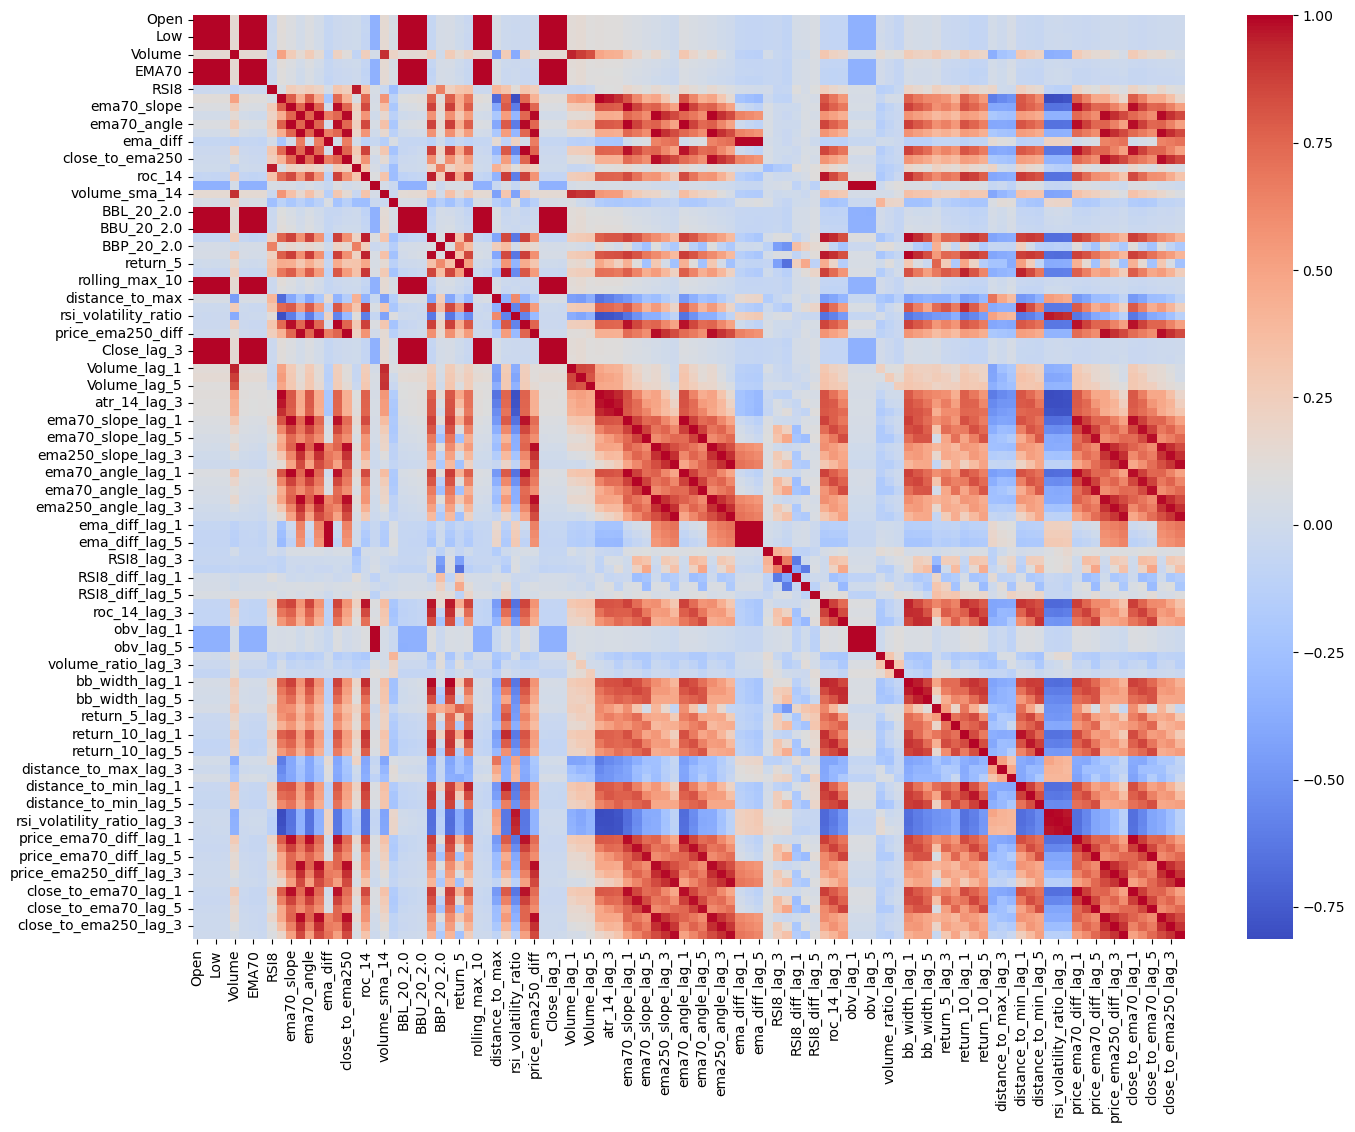

In [174]:
import pandas as pd
import numpy as np

# Copiar el DataFrame para trabajar
df_features = df.copy()

# Eliminar columnas irrelevantes o no numéricas
# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result',
                   #'ohlc_avg','Open','High','Low'
]
df_features = df_features.drop(columns=columns_to_drop)

# Calcular la matriz de correlación
corr_matrix = df_features.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 12))

# Crear el mapa de calor
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

# Mostrar la figura
plt.show()



In [179]:
# Establecer un umbral para considerar una correlación como alta
threshold = 0.99

# Seleccionar las correlaciones que superan el umbral (y no son la diagonal)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            high_corr_pairs.append((colname1, colname2, corr_value))

# Mostrar los pares altamente correlacionados
print("Pares de características con correlación alta (|correlación| > 0.99):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: Correlación = {pair[2]:.2f}")


Pares de características con correlación alta (|correlación| > 0.99):
High - Open: Correlación = 1.00
Low - Open: Correlación = 1.00
Low - High: Correlación = 1.00
Close - Open: Correlación = 1.00
Close - High: Correlación = 1.00
Close - Low: Correlación = 1.00
ohlc_avg - Open: Correlación = 1.00
ohlc_avg - High: Correlación = 1.00
ohlc_avg - Low: Correlación = 1.00
ohlc_avg - Close: Correlación = 1.00
EMA70 - Open: Correlación = 1.00
EMA70 - High: Correlación = 1.00
EMA70 - Low: Correlación = 1.00
EMA70 - Close: Correlación = 1.00
EMA70 - ohlc_avg: Correlación = 1.00
EMA250 - Open: Correlación = 1.00
EMA250 - High: Correlación = 1.00
EMA250 - Low: Correlación = 1.00
EMA250 - Close: Correlación = 1.00
EMA250 - ohlc_avg: Correlación = 1.00
EMA250 - EMA70: Correlación = 1.00
ema70_angle - ema70_slope: Correlación = 1.00
ema250_angle - ema250_slope: Correlación = 1.00
close_to_ema250 - ema250_slope: Correlación = 0.99
close_to_ema250 - ema250_angle: Correlación = 0.99
BBL_20_2.0 - Open: C

In [89]:
# que he probado

columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result', 'tr', # RandomForestClassifier: Mean AUC Score=0.543
                   'High','Open','Low','ohlc_avg', # RandomForestClassifier: Mean AUC Score=0.533
                   'EMA70','EMA250','ema70_slope','ema250_slope',#RandomForestClassifier: Mean AUC Score=0.503
                   'RSI8_diff'
]

La primera columna son los features basicos sin lag optienen la mejor calificacion
la segunda es filtrando los features corrleaciones en una primera instancia
la tercera y cuarto eliminando todos los features correlacionados

Disminuye el AUC score

2)De las features mas importantes al eliminar las correlaciones
# Definir los features que vamos a agregar con lags
features = ['obv', 'Close', 'RSI8', 'ema_diff', 'close_to_ema250', 'Volume', 'atr_14', 'close_to_ema70']

# Crear lags para cada feature espaciados cada 5 velas
for feature in features:
    for lag in range(5, 26, 5):  # Crearemos lags espaciados: 5, 10, 15, 20, 25
        df_trading[f'{feature}_lag_{lag}'] = df_trading[feature].shift(lag)

Esto me ha dado un valor interesante de RandomForestClassifier: Mean AUC Score=0.533

Procedo a aplicar el primero enfqoue agregando estos lag espaciados a todas las features primeramente.

Es el mas alto con RandomForestClassifier: Mean AUC Score=0.546

Tomo todos los features y le aplico 3 lag espaciados de 5 velas y obtengo este score



SyntaxError: invalid syntax (3426351526.py, line 9)

# Random

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Eliminar las columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result', 'tr']
X = df.drop(columns=columns_to_drop)
y = df['result']

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],        # Aumentar el número de árboles
    'max_depth': [10, 20, 30, 40, None],           # Aumentar la profundidad máxima
    'min_samples_split': [2, 5, 10, 15],           # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 6],              # Mínimo número de muestras en una hoja
    'max_features': ['sqrt', 'log2'],              # 'sqrt' será el valor por defecto, y 'log2' como opción adicional
    'bootstrap': [True, False],                    # Usar bootstrap en el muestreo
    'criterion': ['gini', 'entropy'],              # Criterio para medir la calidad de la división
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=10)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")

Mejores Hiperparámetros: {'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini', 'bootstrap': False}
Mejor modelo después de optimización: RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=1500,
                       random_state=42)


In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import joblib

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_random_forest = RandomForestClassifier(
    n_estimators=1500, 
    max_depth=30, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='sqrt', 
    criterion='gini', 
    bootstrap=False, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=10)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_random_forest.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_random_forest.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 10 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")



Fold: Accuracy = 0.441, F1-Score = 0.472, Precision = 0.425, Recall = 0.531

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.46      0.36      0.41        36
         1.0       0.42      0.53      0.47        32

    accuracy                           0.44        68
   macro avg       0.44      0.45      0.44        68
weighted avg       0.45      0.44      0.44        68

Matriz de Confusión:
[[13 23]
 [15 17]]
Fold: Accuracy = 0.456, F1-Score = 0.493, Precision = 0.439, Recall = 0.562

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.48      0.36      0.41        36
         1.0       0.44      0.56      0.49        32

    accuracy                           0.46        68
   macro avg       0.46      0.46      0.45        68
weighted avg       0.46      0.46      0.45        68

Matriz de Confusión:
[[13 23]
 [14 18]]
Fold: Accuracy = 0.500, F1-Score = 0.514, Precision = 0.667,

In [111]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl
joblib.dump(modelo_random_forest, 'modelo_random_forest_8-10-2022.pkl')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


# Aqui entranmos con el X_reduced_forest al XBG para ver si obtengo un mejor reusltado de precision y asi volver a hacaer la prueba

In [71]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Eliminar las columnas irrelevantes para el modelado
X = X_reduced_forest.copy()
y = df['result']

# Definir el modelo XGBClassifier
clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Hiperparámetros ampliados para optimización de XGBClassifier
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],        # Número de árboles
    'max_depth': [3, 5, 10, 20],                   # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0],                  # Submuestreo de datos
    'colsample_bytree': [0.6, 0.8, 1.0],           # Submuestreo de columnas en cada árbol
    'gamma': [0, 0.1, 0.3, 0.5],                   # Umbral de reducción de pérdida mínima
    'reg_alpha': [0, 0.1, 0.5, 1],                 # Regularización L1
    'reg_lambda': [1, 1.5, 2],                     # Regularización L2
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=10)

# Realizar la búsqueda de hiperparámetros con RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores Hiperparámetros: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 1500, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}
Mejor modelo después de optimización: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


In [72]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo XGBClassifier con los mejores hiperparámetros
modelo_xgb = XGBClassifier(
    subsample=1.0, 
    reg_lambda=2, 
    reg_alpha=0.1, 
    n_estimators=1500, 
    max_depth=3, 
    learning_rate=0.05, 
    gamma=0.1, 
    colsample_bytree=0.6, 
    random_state=42,
    eval_metric='logloss', 
    use_label_encoder=False  # Evitar advertencias en versiones recientes de XGBoost
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=10)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_xgb.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_xgb.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de Clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 10 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.530, F1-Score = 0.608, Precision = 0.522, Recall = 0.727

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.55      0.33      0.42        33
         1.0       0.52      0.73      0.61        33

    accuracy                           0.53        66
   macro avg       0.54      0.53      0.51        66
weighted avg       0.54      0.53      0.51        66

Matriz de Confusión:
[[11 22]
 [ 9 24]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.561, F1-Score = 0.580, Precision = 0.513, Recall = 0.667

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.63      0.47      0.54        36
         1.0       0.51      0.67      0.58        30

    accuracy                           0.56        66
   macro avg       0.57      0.57      0.56        66
weighted avg       0.58      0.56      0.56        66

Matriz de Confusión:
[[17 19]
 [10 20]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.470, F1-Score = 0.545, Precision = 0.583, Recall = 0.512

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.33      0.40      0.36        25
         1.0       0.58      0.51      0.55        41

    accuracy                           0.47        66
   macro avg       0.46      0.46      0.45        66
weighted avg       0.49      0.47      0.48        66

Matriz de Confusión:
[[10 15]
 [20 21]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.485, F1-Score = 0.528, Precision = 0.442, Recall = 0.655

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.57      0.35      0.43        37
         1.0       0.44      0.66      0.53        29

    accuracy                           0.48        66
   macro avg       0.50      0.50      0.48        66
weighted avg       0.51      0.48      0.47        66

Matriz de Confusión:
[[13 24]
 [10 19]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.606, F1-Score = 0.606, Precision = 0.714, Recall = 0.526

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.53      0.71      0.61        28
         1.0       0.71      0.53      0.61        38

    accuracy                           0.61        66
   macro avg       0.62      0.62      0.61        66
weighted avg       0.63      0.61      0.61        66

Matriz de Confusión:
[[20  8]
 [18 20]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.545, F1-Score = 0.531, Precision = 0.500, Recall = 0.567

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.59      0.53      0.56        36
         1.0       0.50      0.57      0.53        30

    accuracy                           0.55        66
   macro avg       0.55      0.55      0.55        66
weighted avg       0.55      0.55      0.55        66

Matriz de Confusión:
[[19 17]
 [13 17]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.591, F1-Score = 0.557, Precision = 0.654, Recall = 0.486

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.55      0.71      0.62        31
         1.0       0.65      0.49      0.56        35

    accuracy                           0.59        66
   macro avg       0.60      0.60      0.59        66
weighted avg       0.61      0.59      0.59        66

Matriz de Confusión:
[[22  9]
 [18 17]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.591, F1-Score = 0.449, Precision = 0.500, Recall = 0.407

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.64      0.72      0.67        39
         1.0       0.50      0.41      0.45        27

    accuracy                           0.59        66
   macro avg       0.57      0.56      0.56        66
weighted avg       0.58      0.59      0.58        66

Matriz de Confusión:
[[28 11]
 [16 11]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.530, F1-Score = 0.392, Precision = 0.476, Recall = 0.333

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.56      0.69      0.62        36
         1.0       0.48      0.33      0.39        30

    accuracy                           0.53        66
   macro avg       0.52      0.51      0.50        66
weighted avg       0.52      0.53      0.51        66

Matriz de Confusión:
[[25 11]
 [20 10]]


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold: Accuracy = 0.439, F1-Score = 0.413, Precision = 0.394, Recall = 0.433

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.48      0.44      0.46        36
         1.0       0.39      0.43      0.41        30

    accuracy                           0.44        66
   macro avg       0.44      0.44      0.44        66
weighted avg       0.44      0.44      0.44        66

Matriz de Confusión:
[[16 20]
 [17 13]]

Promedio Accuracy: 0.535
Promedio F1-Score: 0.521
Promedio Precision: 0.530
Promedio Recall: 0.531


In [73]:
## Aumenta a 0.530 un poco mejor que el random